In [1]:
# System Libraries
import os

# Mathematical Libraries
import numpy as np
import numpy.matlib
from scipy.optimize import curve_fit

# Plotting Libraries
import matplotlib.pyplot as plt

# For saving the text as text in the svg file
plt.rcParams['svg.fonttype'] = 'none'

# For saving the text as curves in the svg file
# plt.rcParams['svg.fonttype'] = 'path'

# Set the font of the text in the svg file
plt.rcParams['font.family'] = 'sans-serif'
plt.rcParams['font.sans-serif'] = 'DejaVu Sans'

# Data management Libraries
import pandas as pd
import pickle

%matplotlib inline

In [61]:
# Spatial Units
cm = 1e-2
mm = 1e-3
um = 1e-6

# Electronic Units
mA = 1e-3
uA = 1e-6
nA = 1e-9

kOhm = 1e3
Ohm = 1

# Optical Units
mW = 1e-3
uW = 1e-6
nW = 1e-9
pW = 1e-12
fW = 1e-15

mCd = 1e-3

Colors used for plots are from the website [David the Math Logic](https://davidmathlogic.com/colorblind/#%23648FFF-%23785EF0-%23DC267F-%23FE6100-%23FFB000). We specifically use the IBM palette so that it is color-blind friendly. As we only need five colors at most per plot, this is sufficient. The following colors are included in this palette
1. <span style="color:#648FFF">Blue 1</span> - #648FFF 
2. <span style="color:#785EF0">Blue 2</span> - #785EF0
3. <span style="color:#DC267F">Pink</span> - #DC267F
4. <span style="color:#FE6100">Dark Orange</span> - #FE6100
5. <span style="color:#FFB000">Orange</span> - #FFB000


Below are some fitting functions that are useful for fitting various data array in the course of this notebook

In [117]:
# Fitting function that is used later at one point to fit a polynomial to a data that is used
def fit_polynomial(x_data, y_data, degree):
    # Fit the polynomial
    coeffs = np.polyfit(x_data, y_data, degree)
    # Generate a polynomial function from the coefficients
    p = np.poly1d(coeffs)
    return p

# Define the function to to fit when the form could be that of a square root. This is used for the following data
# 1. Current vs LED luminescence
# 2. 
def sqrt_fit(x, a, b):
    return a * np.sqrt(x) + b

def straight_line_fit(x, a, b):
    return a * x + b

def log_fit(x, a, b, c):
    return a * np.log(x+b) + c

def log_square_fit(x, a, b, c):
    return a * np.square(np.log(x+b)) + c

def neg_exp_fit(x, a, b, c, d):
    return a * np.exp(-b * x + c) + d

# Obtaining relevant values for calculation

## LED Board Power Measurements

In [95]:
# Loading the CSV file containing the measured LED current
file_loc_meas = os.path.join(os.getcwd(), 'data', 'Power Response','Measurements', '2023-11-14 Power Measurement.csv')
df_meas = pd.read_csv(file_loc_meas, header=0)

# Visualizing the dataframe
df_meas

,Voltage (V),Current (mA),Calculated Current (mA),Approximated,LED Current
0,2.55,23.32,22.368421,22.36,0.96
1,2.65,24.08,23.245614,23.24,0.84
2,2.75,25.04,24.122807,24.12,0.92
3,2.85,25.90,25.000000,25.00,0.90
4,2.95,26.91,25.877193,25.87,1.04
5,3.05,27.74,26.754386,26.75,0.99
6,3.15,28.81,27.631579,27.63,1.18
7,3.25,29.87,28.508772,28.50,1.37
8,3.35,30.84,29.385965,29.38,1.46
9,3.45,31.88,30.263158,30.26,1.62


## LED Luminescence

### Loading the datasheet values
The datasheet values for the current vs absolute luminescence (mcd) for the LED used (150040GS73220) were fitted to a square root function. The fit along with the extracted data was plotted in order to obtain a good visual estimate

C:\Users\nkottap\AppData\Local\Temp\ipykernel_24740\275741433.py:19: RuntimeWarning: invalid value encountered in log
  return a * np.log(x+b) + c


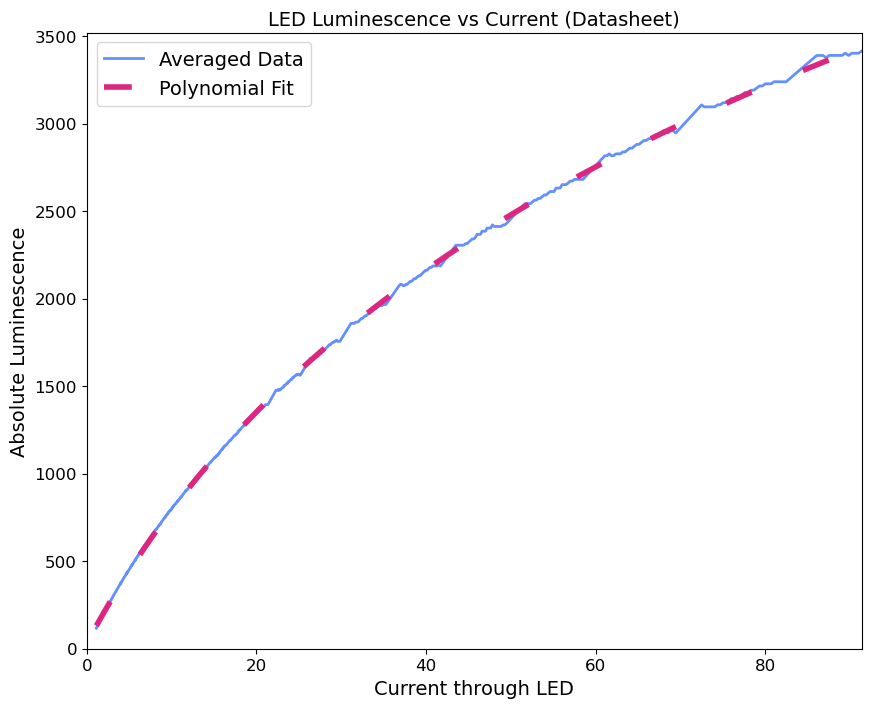

In [168]:
# Loading the CSV file containing the datasheet values of luminescence
file_loc_ds = os.path.join(os.getcwd(), 'data', 'Power Response','LED Datasheet', 'VLMTG1400 Absolute Luminescence.csv')
df_ds = pd.read_csv(file_loc_ds, header=0, index_col=0)

# Convert the stored data in the dataframe to a numpy matrix for ease of processing
ds = np.zeros((len(df_ds), 2))
ds[:,1] = df_ds.to_numpy()[:,0]
ds[:,0] = df_ds.index.values

# Find unique values of the current through the LED
unique_x = np.unique(ds[:, 0])

# Creating a zero array to store the average luminescence for each unique current value. This would account for multiple datapoints per current that were obtained spuriously during extraction
average_y = np.zeros(len(unique_x))

for i, x in enumerate(unique_x):
    indices = np.where(ds[:, 0] == x)
    average_y[i] = np.mean(ds[indices, 1])

# Fitting the fit function for this LED to the
led_lum_fit = log_fit
popt_led_lum, pcov = curve_fit(led_lum_fit, unique_x, average_y)

# Generate a set of x values for the fitted curve
x_fit = np.linspace(min(unique_x), max(unique_x), 1000)

# Evaluate the fitted curve at the x values
luminescence_polynomial_fitted = led_lum_fit(x_fit, *popt_led_lum)


# Plot both the extracted data and the polynomial fitted model for comparison
fig, ax = plt.subplots(figsize=(10, 8))
ax.plot(unique_x, average_y, '-', c='#648FFF', linewidth = 2, label='Averaged Data')
ax.plot(x_fit, luminescence_polynomial_fitted, c='#DC267F', linestyle=(0, (5, 10)), linewidth=4, label='Polynomial Fit')

ax.set_xlim([0, max(ds[:, 0])])
ax.set_ylim([0, max(ds[:, 1])])

ax.tick_params(axis='both', which='major', labelsize=12)

ax.set_xlabel('Current through LED', fontsize=14)
ax.set_ylabel('Absolute Luminescence', fontsize=14)

ax.set_title('LED Luminescence vs Current (Datasheet)', fontsize=14) # Title for plots which are not explicitly used in the moment. Comment this line if needed to export the plot

plt.legend(fontsize=14)

### Calculating the LED luminescence in experiments
During the course of the experiment, the LED intensity was varied by controlling the voltage applied to the circuit with an LED and a resistor. However as this would lead to a change in the current across in circuit and subsequently lead to a change in the brightness of the emission from the LE, we only need to consider the current through the LED. In the following cells, the current across the LED is calculated based on the voltage input signal, subsequent absolute luminescence values for a given current are calculated based on the datasheet obtained values in teh previous section

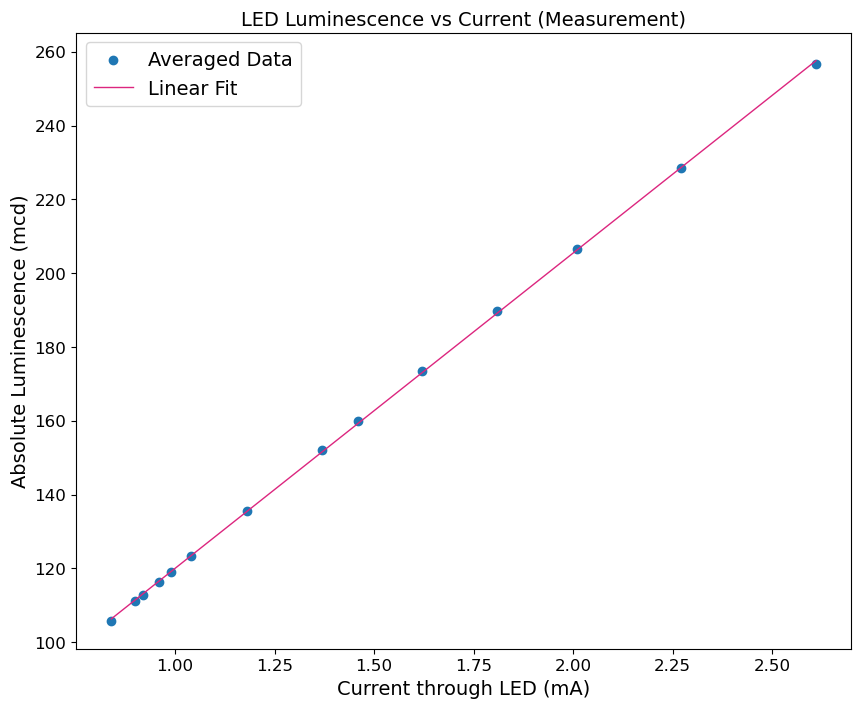

In [167]:
# Calculate the luminescence for the measured values of current
meas_lum = led_lum_fit(df_meas['LED Current'].values, *popt_led_lum)

# Fit an exponential curve to the data
current_lum_fit = straight_line_fit

popt, pcov = curve_fit(current_lum_fit, df_meas['LED Current'], meas_lum)

# Generate a set of x values for the fitted curve
x_fit = np.linspace(min(df_meas['LED Current'].values), max(df_meas['LED Current'].values), 1000)

# Evaluate the fitted curve at the x values
y_fit = current_lum_fit(x_fit, *popt)

# Plot the original data and the fitted curve
fig, ax = plt.subplots(figsize=(10, 8))
ax.scatter(df_meas['LED Current'].values, meas_lum, label='Averaged Data')
ax.plot(x_fit, y_fit, c='#DC267F', linestyle = 'solid', linewidth = 1, label='Linear Fit')

# ax.set_xlim([0, max(ds[:, 0])])
# ax.set_ylim([0, max(ds[:, 1])])

ax.tick_params(axis='both', which='major', labelsize=12)

ax.set_xlabel('Current through LED (mA)', fontsize=14)
ax.set_ylabel('Absolute Luminescence (mcd)', fontsize=14)

ax.set_title('LED Luminescence vs Current (Measurement)', fontsize=14) # Title for plots which are not explicitly used in the moment. Comment this line if needed to export the plot

plt.legend(fontsize=14)


## LED Angular response data (Datasheet)
### Loading the file

In [132]:
# File Location
file_loc_angular_x = 'data\Power Response\LED Datasheet\VLMTG1400 Angular Response X.csv'
file_loc_angular_y = 'data\Power Response\LED Datasheet\VLMTG1400 Angular Response Y.csv'

# Load the data
df_angular_x = pd.read_csv(file_loc_angular_x, header=0)
df_angular_y = pd.read_csv(file_loc_angular_y, header=0)

### Calculating the maximum angle at which light is imaged from the lens

In [136]:
lens_diameter = 40 # mm
lens_radius = lens_diameter/2
lens_focal_length = 100 # mm

max_angle_captured = 2 * np.degrees(np.arctan((lens_radius/(2*lens_focal_length))))
print('The maximum solid angle captured by the lens is {:.2f} degrees'.format(max_angle_captured))

The maximum solid angle captured by the lens is 11.42 degrees


### Plotting the angular response of the LED

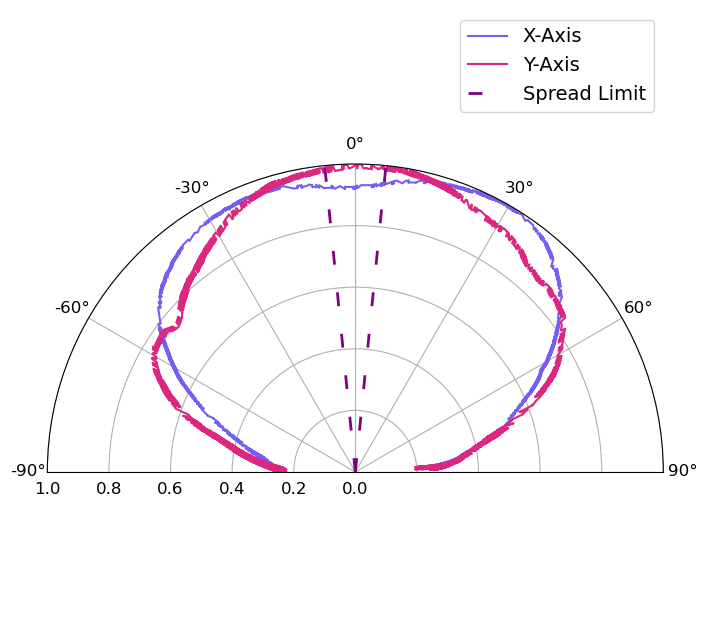

In [171]:
# Modifying the data for plotting the directional properties of the LED
# Shift Angle from 0 to 180 to -90 to 90
df_angular_x['Rot Angle'] = df_angular_x['Angle'] - 90
df_angular_y['Rot Angle'] = df_angular_y['Angle'] - 90

# Plot the data 
fig, ax = plt.subplots(subplot_kw={'projection': 'polar'})
fig.set_figheight(8)
fig.set_figwidth(8)

# Plot data and limit the theta direction to show only the range from -90 to 90
ax.plot(np.radians(df_angular_x['Rot Angle']), df_angular_x['Intensity'], label='X-Axis', c='#785EF0')
ax.plot(np.radians(df_angular_y['Rot Angle']), df_angular_y['Intensity'], label='Y-Axis', c='#DC267F')
ax.set_ylim(0, 1)  # Adjust this if necessary based on your data range

# Add vertical lines at 14.03624347 degrees and -14.03624347 degrees
ax.axvline(np.radians(max_angle_captured/2), color='purple', linestyle=(0, (5, 10)), lw=2, label='Spread Limit')
ax.axvline(np.radians(-max_angle_captured/2), color='purple', linestyle=(0, (5, 10)), lw=2)

# Hide the bottom half by setting the theta limits
ax.set_thetamin(-90)
ax.set_thetamax(90)

ax.tick_params(axis='both', which='major', labelsize=12)

# plt.title("Polar Plot of LED Emission Characteristics")
ax.set_theta_offset(np.pi/2)
ax.set_theta_direction(-1)
plt.legend(fontsize=14)

plt.savefig("out/Power/LED Emission Directionality.pdf", transparent=True)
plt.savefig("out/Power/LED Emission Directionality.png", dpi=800, transparent=True)

### Obtain a fit for the angular response

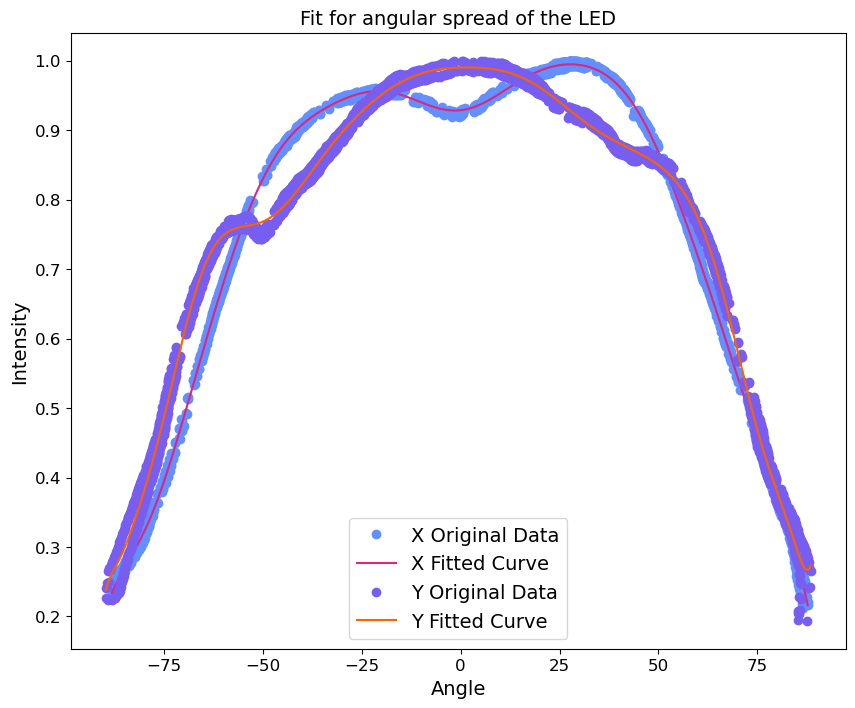

In [166]:
# Fit a polynomial to the data
degree_x = 20 # choose the degree of the polynomial (arbitrarily large to capture the trend without overfitting)

coeffs_x = np.polyfit(df_angular_x['Rot Angle'], df_angular_x['Intensity'], degree_x)

# Generate x values for the fitted curve
x_fit_x = np.linspace(min(df_angular_x['Rot Angle']), max(df_angular_x['Rot Angle']), 1000)

# Evaluate the fitted curve at the x values
y_fit_x = np.polyval(coeffs_x, x_fit_x)

degree_y = 20 # choose the degree of the polynomial
coeffs_y = np.polyfit(df_angular_y['Rot Angle'], df_angular_y['Intensity'], degree_y)

# Generate x values for the fitted curve
x_fit_y = np.linspace(min(df_angular_y['Rot Angle']), max(df_angular_y['Rot Angle']), 1000)

# Evaluate the fitted curve at the x values
y_fit_y = np.polyval(coeffs_y, x_fit_y)

# Plot the original data and the fitted curve
fig, ax = plt.subplots(figsize=(10, 8))
ax.plot(df_angular_x['Rot Angle'], df_angular_x['Intensity'], 'o', label='X Original Data', c='#648FFF')
ax.plot(x_fit_x, y_fit_x, label='X Fitted Curve', c='#DC267F')
ax.plot(df_angular_y['Rot Angle'], df_angular_y['Intensity'], 'o', label='Y Original Data', c='#785EF0')   
ax.plot(x_fit_y, y_fit_y, label='Y Fitted Curve', c='#FE6100')

ax.tick_params(axis='both', which='major', labelsize=12)

ax.set_xlabel('Angle', fontsize=14)
ax.set_ylabel('Intensity', fontsize=14)

ax.set_title('Fit for angular spread of the LED', fontsize=14) # Title for plots which are not explicitly used in the moment. Comment this line if needed to export the plot

plt.legend(fontsize=14)


Shape of the mask is:  (1000, 1000)
The true values in the mask form a square matrix.
The variable pd_incident does not contain NaN values and forms a zero matrix.


<Figure size 640x480 with 0 Axes>

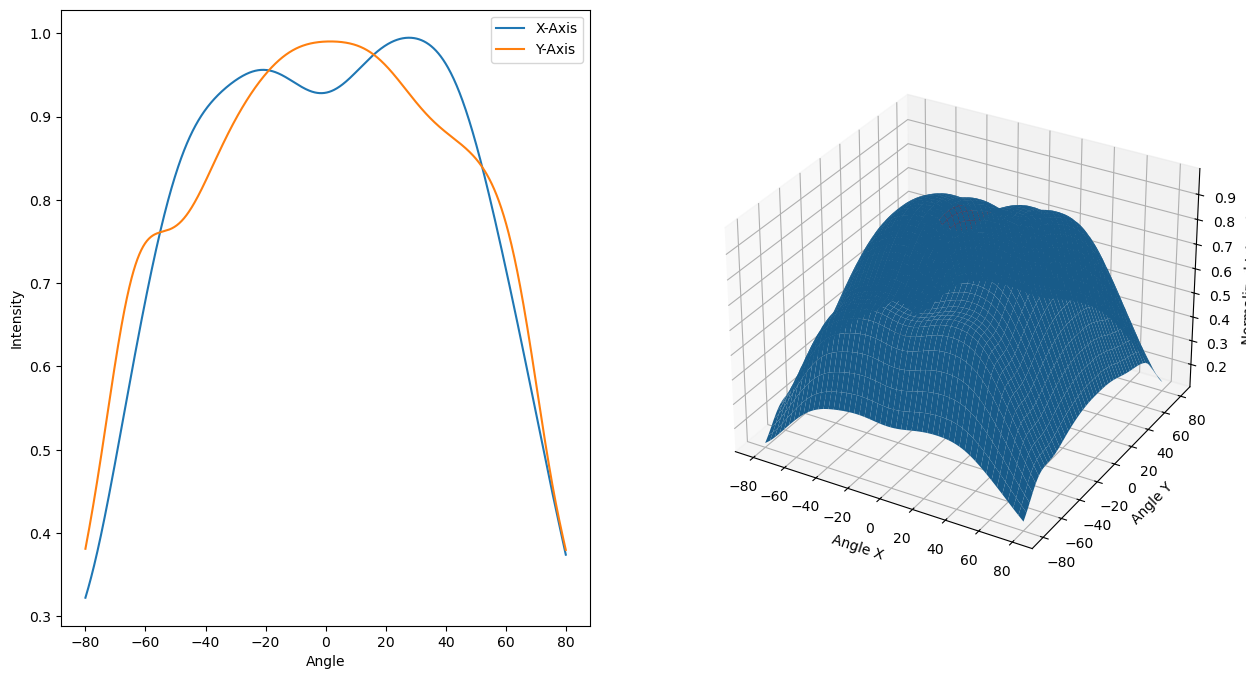

In [164]:
# Generating the desired angles
angle = np.linspace(-80, 80, 1000)  # Restricting the range to -80 to 80 degrees to avoid the edge effects of the fitting
intensity_x = np.polyval(coeffs_x, angle)
intensity_y = np.polyval(coeffs_y, angle)

# Plotting the calculated figures
plt.clf()
fig = plt.figure(figsize=(15, 8))

ax1 = fig.add_subplot(1, 2, 1)
ax1.plot(angle, intensity_x, label='X-Axis')
ax1.plot(angle, intensity_y, label='Y-Axis')
ax1.set_xlabel('Angle')
ax1.set_ylabel('Intensity')
ax1.legend()

# Extending the 1D data to 2D data
intensity_x_2d = np.matlib.repmat(intensity_x, len(intensity_y), 1)
intensity_y_2d = np.matlib.repmat(intensity_y, len(intensity_x), 1).T

# Calculating the total intensity as a product of the two intensities
intensity_total = intensity_x_2d * intensity_y_2d

# Selecting the angles that are relevant for collection by the lens
angle_x, angle_y = np.meshgrid(angle, angle)

# Calculating the relevant mask for the values that are captured by the lens
mask = (angle_x > -max_angle_captured) & (angle_y > -max_angle_captured) & (angle_x < max_angle_captured) & (angle_y < max_angle_captured)
print("Shape of the mask is: ", angle_x.shape)

# Assigning the values outside the mask to NaN to avoid plotting them
modified_intensity_map = np.where(mask, np.nan, intensity_total)

# Calculating a mask that only contains the values that are captured by the lens
selected_intensity_map = np.where(mask, intensity_total, np.nan)

# Verify if the True values in the mask form a square matrix
true_indices = np.argwhere(mask)
rows, cols = true_indices.ptp(axis=0) + 1
print("The true values in the mask form a square matrix." if rows == cols else "The true values in the mask do not form a square matrix.")

# Check if the relevant section has any NaN values
pd_incident = selected_intensity_map[true_indices[:, 0].min():true_indices[:, 0].max()+1, true_indices[:, 1].min():true_indices[:, 1].max()+1]
print("The variable pd_incident contains NaN values." if np.isnan(pd_incident).any() else "The variable pd_incident does not contain NaN values and forms a zero matrix.")

# Plotting the surface
ax2 = fig.add_subplot(1, 2, 2, projection='3d')
surf = ax2.plot_surface(angle_x, angle_y, modified_intensity_map)
surf2 = ax2.plot_surface(angle_x, angle_y, selected_intensity_map, color='red')
ax2.set_xlabel('Angle X')
ax2.set_ylabel('Angle Y')
ax2.set_zlabel('Normalized Intensity')

plt.show()


In [14]:
##################################################################################
# Irrelevant code as this section has been done with the interpolated code above #
# However, still need to be calculated to get a good estimate of the percent     #
# of the original light that is incident on the photodiode                       #
##################################################################################

# Calculating the product using matrix multiplications
x_rep_mat = np.matlib.repmat(df_angular_x['Intensity'], len(df_angular_y['Intensity']), 1)
y_rep_mat = np.matlib.repmat(df_angular_y['Intensity'], len(df_angular_x['Intensity']), 1).T
intensity_map = x_rep_mat * y_rep_mat

# Creating the angular map
angle_a, angle_b = np.meshgrid(df_angular_x['Angle'], df_angular_y['Angle'])

# Filter the values to the level where they would be captured by the 2-inch lens used
condition_x = (df_angular_x['Angle'] >= -max_angle_captured) & (df_angular_x['Angle'] <= max_angle_captured)
condition_y = (df_angular_y['Angle'] >= -max_angle_captured) & (df_angular_y['Angle'] <= max_angle_captured)

# Generating a new dataframe based on the values used in the filterr
df_angular_x_filter = df_angular_x.loc[condition_x]
df_angular_y_filter = df_angular_y.loc[condition_y]

# Calculating the product again for this new limited map
x_rep_mat_filter = np.matlib.repmat(df_angular_x_filter['Intensity'], len(df_angular_y_filter['Intensity']), 1)
y_rep_mat_filter = np.matlib.repmat(df_angular_y_filter['Intensity'], len(df_angular_x_filter['Intensity']), 1).T
intensity_map_filter = x_rep_mat_filter * y_rep_mat_filter

angle_a_filter, angle_b_filter = np.meshgrid(df_angular_x_filter['Angle'], df_angular_y_filter['Angle'])

In [15]:
# Calculating the percentage of light that is actually captured by the lens
percentage_captured = np.sum(intensity_map_filter) / np.sum(intensity_map)
print(f"The percentage of light captured by the lens is {percentage_captured * 100:.2f}%")

The percentage of light captured by the lens is 1.46%


In [16]:
##################################################################################
# Irrelevant code as this section has been done with the interpolated code above #
# Hoever the code is for the original data instead of the interpolated data      #
# and kept for reference purposes                                                #
##################################################################################

# fig, ax = plt.subplots(subplot_kw={"projection": "3d"})
# mask = (angle_a > -max_angle_captured) & (angle_b > -max_angle_captured) & (angle_a < max_angle_captured) & (angle_b < max_angle_captured)

# print("Shape of the mask is: ", angle_a.shape)
# modified_intensity_map = np.where(mask, np.nan, intensity_map)
# surf = ax.plot_surface(angle_a, angle_b, modified_intensity_map)
# ax.set_xlabel('Angle X')
# ax.set_ylabel('Angle Y')
# ax.set_zlabel('Normalized Intensity')
# highlighted_surf = ax.plot_surface(angle_a_filter, angle_b_filter, intensity_map_filter, color='red')



### Extend to a 2D image

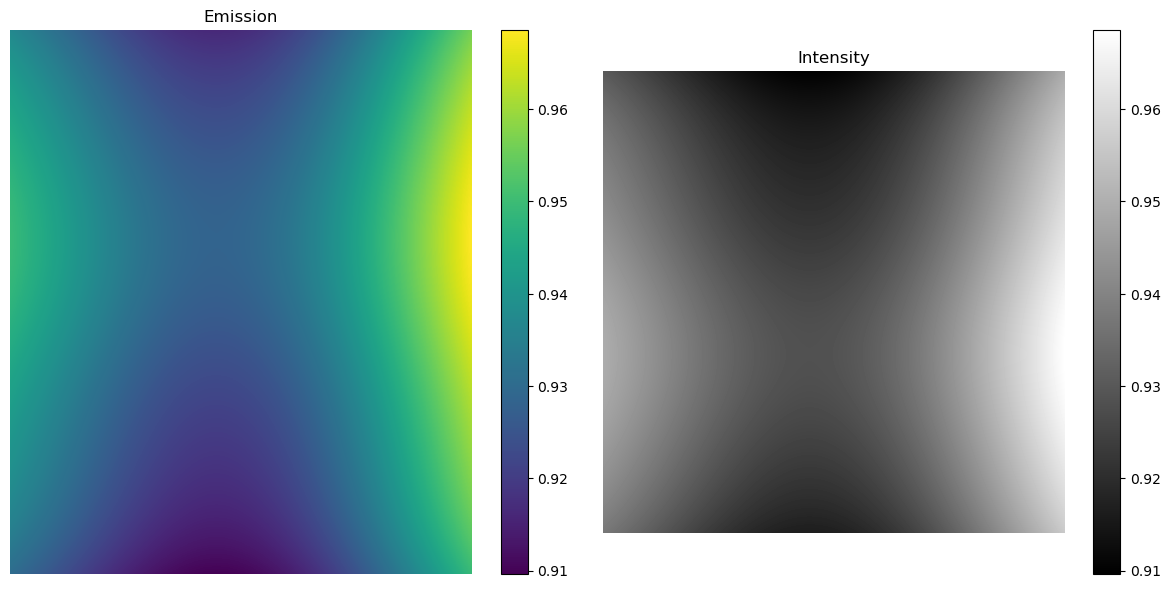

In [17]:
# Creating a meshgrid of points
x_grid, y_grid = np.meshgrid(np.linspace(-max_angle_captured, max_angle_captured, 1000), np.linspace(-max_angle_captured, max_angle_captured, 1000))

# Calculating the intensity at each point
z_grid = np.zeros(x_grid.shape)
for i in range(len(x_grid)):
    for j in range(len(x_grid[0])):
        z_grid[i, j] = np.polyval(coeffs_x, x_grid[i, j]) * np.polyval(coeffs_y, y_grid[i, j])

# Normalizing z_grid
z_grid /= np.max(y_fit_y)

emission_fit = np.stack((x_grid, y_grid, z_grid), axis=-1)

# Displaying the data
plt.figure(figsize=(12, 6))

# Subplot 1
plt.subplot(1, 2, 1)
plt.pcolormesh(emission_fit[...,0], emission_fit[...,1], emission_fit[...,2])
plt.xticks([])
plt.yticks([])
plt.axis('off')
plt.title('Emission')
plt.colorbar()

# Subplot 2
plt.subplot(1, 2, 2)
plt.imshow(emission_fit[...,2], cmap='gray')
plt.axis('off')
plt.title('Intensity')
plt.colorbar()

plt.tight_layout()
plt.show()

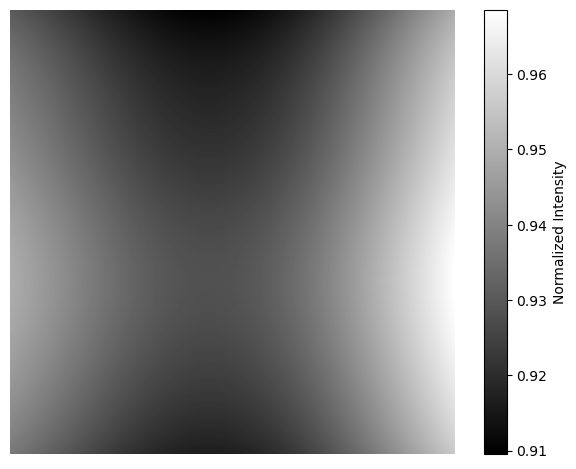

In [19]:
plt.clf()
plt.imshow(emission_fit[...,2], cmap='gray')
plt.axis('off')
# plt.title('LED Intensity at Emission Plane')
cbar = plt.colorbar()
cbar.set_label("Normalized Intensity")

plt.tight_layout()
plt.savefig("out/Power/LED Output Intensity.pdf", transparent=True)
plt.savefig("out/Power/LED Output Intensity.png", dpi=800, transparent=True)
plt.show()

## Photodiode Angular Data

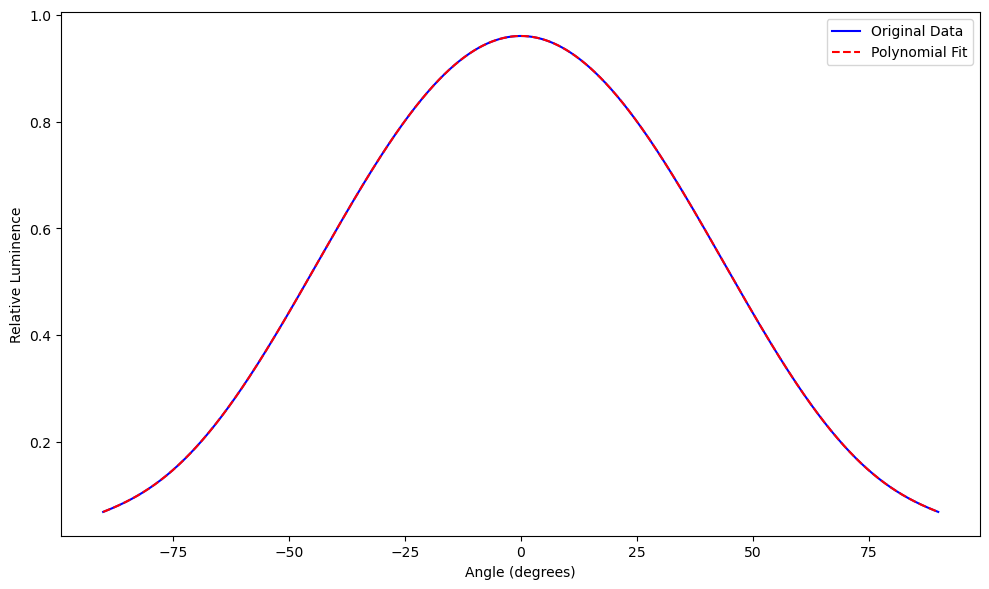

In [20]:
file_loc_pd = 'data\Power Response\PD Datasheet\SFH2704 Directional Fit.csv'

# Reading the CSV file
df_pd = pd.read_csv(file_loc_pd, header=0)
pd_df_headers = df_pd.columns.values

# Performing a polynomial fit
degree_pd = 7
pd_polyfit = fit_polynomial(df_pd[pd_df_headers[0]].to_numpy(), df_pd[pd_df_headers[1]].to_numpy(), degree_pd)

# Plot the fitted polynomial
plt.figure(figsize=(10, 6))
plt.plot(df_pd[pd_df_headers[0]].to_numpy(), df_pd[pd_df_headers[1]].to_numpy(), c='blue', label='Original Data')
plt.plot(df_pd[pd_df_headers[0]].to_numpy(), pd_polyfit(df_pd[pd_df_headers[0]].to_numpy()), c='red', linestyle='--', label='Polynomial Fit')
plt.xlabel('Angle (degrees)')
plt.ylabel('Relative Luminence')
# plt.title('Relative Luminence vs Angle for the Photodiode')
plt.legend()

plt.tight_layout()

plt.savefig("out/Power/Photodiode Directional Plot.pdf", transparent=True)
plt.savefig("out/Power/Photodiode Directional Plot.png", dpi=800, transparent=True)

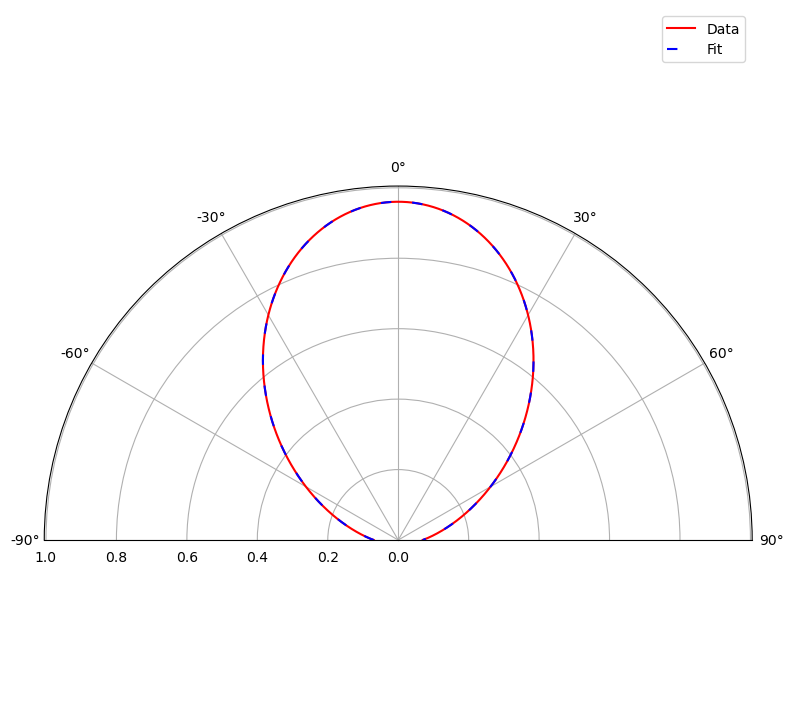

In [21]:


# Plot the data 
fig, ax = plt.subplots(subplot_kw={'projection': 'polar'})
fig.set_figheight(8)
fig.set_figwidth(8)

# Plot data and limit the theta direction to show only the range from -90 to 90

ax.plot(np.radians(df_pd[pd_df_headers[0]]).to_numpy(), df_pd[pd_df_headers[1]].to_numpy(), label='Data', c='red')
ax.plot(np.radians(df_pd[pd_df_headers[0]]).to_numpy(), pd_polyfit(df_pd[pd_df_headers[0]].to_numpy()), label='Fit', c='blue', linestyle=(0, (5, 10)))

# ax.set_ylim(0, 1)  # Adjust this if necessary based on your data range

# # Add vertical lines at 14.03624347 degrees and -14.03624347 degrees
# ax.axvline(np.radians(14.03624347), color='purple', linestyle=(0, (5, 10)), lw=2, label='Spread Limit')
# ax.axvline(np.radians(-14.03624347), color='purple', linestyle=(0, (5, 10)), lw=2)

# # Hide the bottom half by setting the theta limits
ax.set_thetamin(-90)
ax.set_thetamax(90)

# # plt.title("Polar Plot of LED Emission Characteristics")
ax.set_theta_offset(np.pi/2)
ax.set_theta_direction(-1)
plt.legend()

plt.tight_layout()
plt.savefig("out/Power/PD Detection Directionality.pdf", transparent=True)
plt.savefig("out/Power/PD Detection Directionality.png", dpi=800, transparent=True)

## Loading the Intermediate board power measurements

C:\Users\nkottap\AppData\Local\Temp\ipykernel_24740\3070936281.py:27: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax1.set_xticklabels(inter_vals[:,0], fontsize=12)
C:\Users\nkottap\AppData\Local\Temp\ipykernel_24740\3070936281.py:28: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax1.set_yticklabels(inter_vals[:,1], fontsize=12)


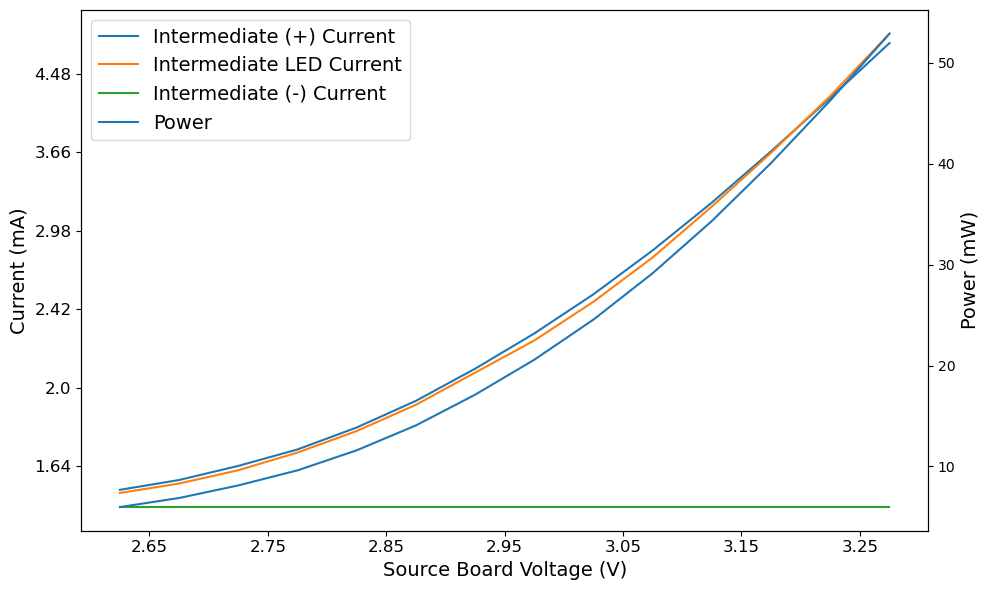

,Source Board Voltage,Source Current,Intermediate (+) Current,Intermediate (-) Current,Intermediate LED Current,Total Power (mW)
0,2.55,0.96,1.39,0.95,1.31,5.9670
1,2.65,0.84,1.64,0.95,1.55,6.8635
2,2.75,0.92,2.00,0.95,1.89,8.1125
3,2.85,0.90,2.42,0.95,2.34,9.6045
4,2.95,1.04,2.98,0.95,2.89,11.5935
5,3.05,0.99,3.66,0.95,3.56,14.0605
6,3.15,1.18,4.48,0.95,4.38,17.1045
7,3.25,1.37,5.38,0.95,5.20,20.5725
8,3.35,1.46,6.38,0.95,6.19,24.5555
9,3.45,1.62,7.50,0.95,7.32,29.1525


In [22]:
# Loading the intermediate file 
file_loc_inter = os.path.join(os.getcwd(), 'data', 'Power Response','Measurements', '2023-10-30 Intermediate Board Measuremetnts.csv')
df_inter = pd.read_csv(file_loc_inter, header=0)

# Converting to numpy array
inter_vals = np.zeros((len(df_inter), 4))
inter_vals[:,0] = df_inter['Source Board Voltage'].to_numpy()
inter_vals[:,1] = df_inter['Intermediate (+) Current'].to_numpy()
inter_vals[:,2] = df_inter['Intermediate (-) Current'].to_numpy()
inter_vals[:,3] = df_inter['Intermediate LED Current'].to_numpy()

# Calculate the power consumed
total_pow = inter_vals[:,0] * (inter_vals[:,1] + inter_vals[:,2])

# Check if the 'Total Power (mW)' column already exists
if 'Total Power (mW)' not in df_inter.columns:
    # Insert the 'Total Power (mW)' column into the dataframe
    df_inter.insert(5, 'Total Power (mW)', total_pow, True)

# Plotting the Voltage v/s current curve

fig,ax1 = plt.subplots(figsize=(10, 6))
line1, = ax1.plot(inter_vals[:,0], inter_vals[:,1], label='Intermediate (+) Current')
line2, = ax1.plot(inter_vals[:,0], inter_vals[:,3], label='Intermediate LED Current')
line3, = ax1.plot(inter_vals[:,0], inter_vals[:,2], label='Intermediate (-) Current')

ax1.set_xticklabels(inter_vals[:,0], fontsize=12)
ax1.set_yticklabels(inter_vals[:,1], fontsize=12)

ax1.tick_params(axis='y', labelcolor='black')
ax1.set_xlabel('Source Board Voltage (V)', fontsize=14)
ax1.set_ylabel('Current (mA)', fontsize=14)

ax2 = ax1.twinx()
line4, = ax2.plot(inter_vals[:,0], total_pow, label='Power')

# ax2.set_yticklabels(total_pow, fontsize=12)
ax2.set_ylabel('Power (mW)', fontsize=14)

# Combine legends from both axes
lines = [line1, line2, line3, line4]
labels = [line.get_label() for line in lines]
ax1.legend(lines, labels, loc='upper left', fontsize=14)

plt.tight_layout()
plt.savefig("out/Power/Intermediate Board Power Consumption.pdf", transparent=True)
plt.savefig("out/Power/Intermediate Board Power Consumption.png", dpi=800, transparent=True)
plt.show()

df_inter

In [23]:
# from  df_inter, drop columns 'Source Board Voltage' and 'Source Current' and save the rest of the dataframe along with the headings to a csv file named '2024-01-04 Selected Data.csv'
df_selected = df_inter.drop(['Source Board Voltage', ], axis=1)
df_selected = df_selected.round(2)
df_selected = df_selected.astype(float).apply(lambda x: round(x, 2))
df_selected.to_csv('out/Power/2024-01-04 Selected Data.csv', index=False)
 
latex_table = df_selected.to_latex(index=False, float_format='%.2f')
markdown_table = df_selected.to_markdown(index=False, floatfmt=".2f")
print(markdown_table)


|   Source Current |   Intermediate (+) Current |   Intermediate (-) Current |   Intermediate LED Current |   Total Power (mW) |
|-----------------:|---------------------------:|---------------------------:|---------------------------:|-------------------:|
|             0.96 |                       1.39 |                       0.95 |                       1.31 |               5.97 |
|             0.84 |                       1.64 |                       0.95 |                       1.55 |               6.86 |
|             0.92 |                       2.00 |                       0.95 |                       1.89 |               8.11 |
|             0.90 |                       2.42 |                       0.95 |                       2.34 |               9.60 |
|             1.04 |                       2.98 |                       0.95 |                       2.89 |              11.59 |
|             0.99 |                       3.66 |                       0.95 |                   

# Estimating the Optical Transfer Function
The idea is to use the directionality of the instensity emitted from the LED VLMTG1400 and extimate how much total light might be incident on the LED. We can achieve this by calculating the magnification factor of the 

$$
\mathcal M = \frac{y_2}{y_1} = -\frac{z_2}{z_1}
$$

Which indicates that the size of the formed image is a magnified and inverted version of the detected image. I physically measure the image spot that is formed on the photodiode surface plane which I estimate to not change significantly for the distance between photodiode plane and detector plane. We further assume tha the photodiode is positioned at the center of the The total amount of light can be calculated from the light collected by the lens, imperfections in the lens and the amount of area in the image covered by the photodiode. As the distance between the lens ($d_1$) and the LED ($l_{LED}$) is much larger than the dimension of the emitter in the LED, i.e. $l_{LED} \gg d_1$, we can consider 
the LED to be a point source. So we can calculate the amount of light collected by the lens as follows

We follow these steps
1. **Calculate the aperture of the lens:** As the diameter of the lens is 25.4mm, that is also the aperture of the lens
 
2. **Calculate the solid angle:** The solid angle of the arc of light incident on the lens can be calculated using 
    $$ \Omega = 2 \pi (1 - \cos \theta)$$
    The $\cos \theta$ term needed to determine the solid angle can be calculated. For a lens place at the distance $z_1$ and radius of the lens $r_l$
            $$ \cos \theta = \frac{z_1}{\sqrt{z_1^2 + r^2}}$$

3. **Estimate the distribution of luminescence collected by the lens:** The total amount of light that is incident upon the photodiode depends on luminescence distribution. However, that depends on the solid angle that is the maximum covering the aperture of the lens. So we can cut off the sections that are outside the solid angle. This can be propagated to the image plane where the detector surface is

4. **Estimate the distribution of luminescence on the detector**: Based on what percentage of the detector surface covers the distribution of luminescence imaged from the lens, we can calculate the total luminescence incident on the surface of the lens

5. **Calculate the intensity on the photodiode**: As 1W = 683 lumens, we can calculate the intensity in $\frac{W}{cm^2}$

**Assumptions**
1. The LED, lens and the photodiode are centered with respect to each other.
2. The distance between the emitter and the lens is quite large compared to the emitter size

**Links**
1. [Edmund Optics](https://www.edmundoptics.com/knowledge-center/application-notes/optics/optics-application-examples/#:~:text=Solid%20angle%20is%20defined%20as,%CE%A9%20or%20%CE%A9'%2C%20respectively.)
2. [ChatGPT](https://chat.openai.com/share/d4a87d83-a697-47c8-98ad-9012b5469c3b)

## Calculating the angle subtended by the lens

In [24]:
em_lens_dist = 120 * mm
lens_det_dist = 100 * mm

# Caclculating the cosine theta term
cos_theta = em_lens_dist**2 / np.sqrt(em_lens_dist**2 + (lens_diameter / 2)**2)

# Calculating the solid angle
solid_angle = 2 * np.pi * (1 - cos_theta)
# solid_angle = np.rad2deg(np.pi * (lens_diameter / 2)**2 / lens_dist**2)

# Calculating throughput
refraction_index = 1.5
throughput = refraction_index**2 * solid_angle * np.pi * (lens_diameter / 2)**2 

# Finding the angle
angle = np.rad2deg(2 * np.arctan(lens_diameter / (2 * em_lens_dist)) )

In [25]:
# Cropping emission_fit to the angles accepted by the lens
mask_x = np.logical_and(x_grid >= -angle/2, x_grid <= angle/2)
mask_y = np.logical_and(y_grid >= -angle/2, y_grid <= angle/2)
mask = np.logical_and(mask_x, mask_y)

emission_fit_masked = emission_fit.copy()
emission_fit_masked[~mask] = 0

# Finding the ratio of emissions
emission_fit_ratio = np.sum(emission_fit_masked[:,:,2]) / np.sum(emission_fit[:,:,2])
 
em_fit_m = np.argwhere(emission_fit_masked[:,:,2])
x_min, y_min = em_fit_m.min(axis=0)
x_max, y_max = em_fit_m.max(axis=0)

# emission_fit_cropped = emission_fit_masked[x_min:x_max, y_min:y_max, :]
# The code above has not been used as the calculation is incorrect since the angle projection
emission_fit_cropped = pd_incident

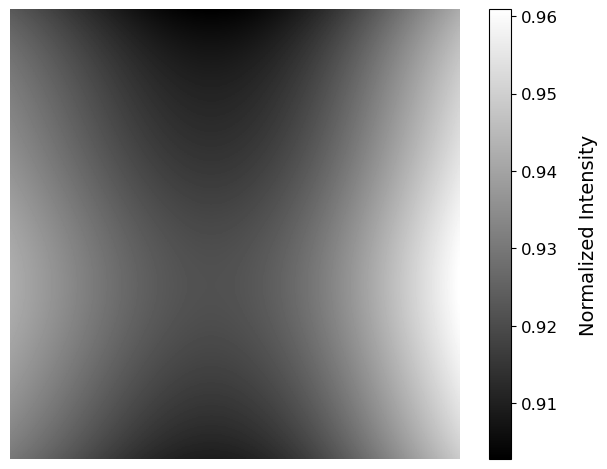

In [26]:
# Saving the part of the LED signal incident on the photodiode 
plt.clf()
plt.imshow(emission_fit_cropped, cmap='gray')
plt.axis('off')
# plt.title('LED Intensity at Emission Plane')
cbar = plt.colorbar()
cbar.ax.tick_params(labelsize=12)
# Increase the gap between the ticklaberl and the colorbar label
cbar.ax.yaxis.labelpad = 15

cbar.set_label("Normalized Intensity", fontsize=14)
plt.tight_layout()

plt.savefig("out/Power/LED Signal for PD.pdf", transparent=True)
plt.savefig("out/Power/LED Signal for PD.png", dpi=800, transparent=True)
plt.show()



C:\Users\nkottap\AppData\Local\Temp\ipykernel_24740\3630041938.py:3: UserWarning: The input coordinates to pcolormesh are interpreted as cell centers, but are not monotonically increasing or decreasing. This may lead to incorrectly calculated cell edges, in which case, please supply explicit cell edges to pcolormesh.
  plt.pcolormesh(emission_fit_cropped, emission_fit_cropped, emission_fit_cropped, cmap='gray')


<Figure size 640x480 with 0 Axes>

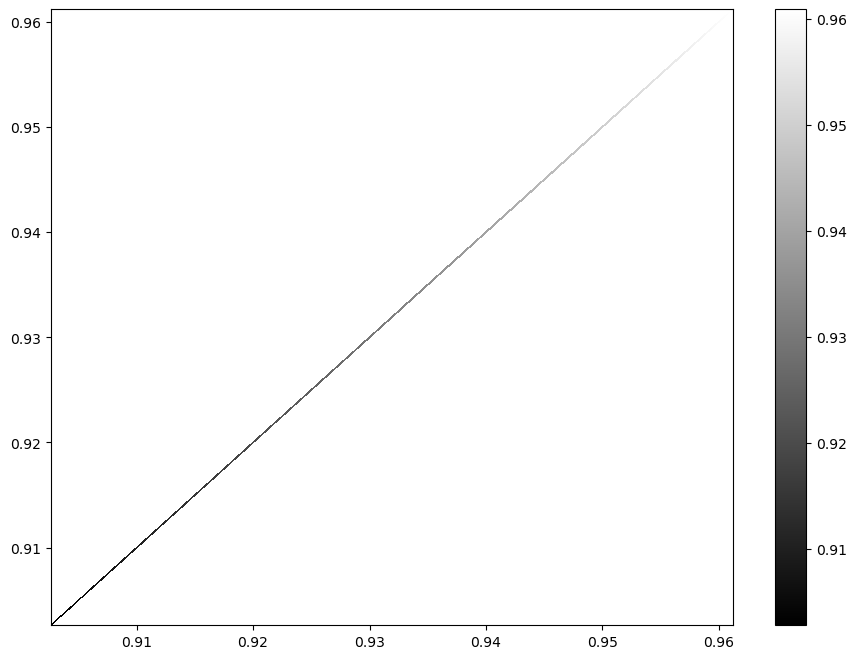

In [27]:
plt.clf()
plt.figure(figsize=(11, 8))
plt.pcolormesh(emission_fit_cropped, emission_fit_cropped, emission_fit_cropped, cmap='gray')
plt.colorbar()
plt.show()

## Estimating the final intensity on the photodiode
### Modifying the image

In [51]:
# Defining Sizes
emitter_size = [500*um, 500*um]
detector_size = [1.4*mm, 1.4*mm]
spot_size = [3*mm, 3*mm]
magnification = [emitter_size[0]/detector_size[0], emitter_size[1]/detector_size[1]]

In [29]:
#####################################################################################
# Old code that only considered the old form of structuring arrays for calculation. #
# Kept here for reference                                                           #
#####################################################################################

# # Cropping and swapping the axes of the light collected by the LED and that is imaged onto the detector. This follows a thin lens approximation
# # Creating the meshgrid of points
# spot_x, spot_y = np.meshgrid(np.linspace(-spot_size[0]/2, spot_size[0]/2, emission_fit_cropped.shape[1]), np.linspace(-spot_size[1]/2, spot_size[1]/2, emission_fit_cropped.shape[0]))

# # Creating a new array spot that holds the final information
# spot = np.zeros((emission_fit_cropped.shape[0], emission_fit_cropped.shape[1], 3))
# spot[...,0] = spot_x
# spot[...,1] = spot_y

# # Seleccting the relevant segments
# inter_spot_00 = np.flip(emission_fit_cropped[0:emission_fit_cropped.shape[0]//2, 0:emission_fit_cropped.shape[1]//2,  2])
# inter_spot_01 = np.flip(emission_fit_cropped[emission_fit_cropped.shape[0]//2:emission_fit_cropped.shape[0], 0:emission_fit_cropped.shape[1]//2,  2])
# inter_spot_10 = np.flip(emission_fit_cropped[0:emission_fit_cropped.shape[0]//2, emission_fit_cropped.shape[1]//2:emission_fit_cropped.shape[1],  2])
# inter_spot_11 = np.flip(emission_fit_cropped[emission_fit_cropped.shape[0]//2:emission_fit_cropped.shape[0], emission_fit_cropped.shape[1]//2:emission_fit_cropped.shape[1],  2])

# # Swappign the indices
# spot[0:emission_fit_cropped.shape[0]//2, 0:emission_fit_cropped.shape[1]//2,  2] = inter_spot_11
# spot[emission_fit_cropped.shape[0]//2:emission_fit_cropped.shape[0], 0:emission_fit_cropped.shape[1]//2,  2] = inter_spot_10
# spot[0:emission_fit_cropped.shape[0]//2, emission_fit_cropped.shape[1]//2:emission_fit_cropped.shape[1],  2] = inter_spot_01
# spot[emission_fit_cropped.shape[0]//2:emission_fit_cropped.shape[0], emission_fit_cropped.shape[1]//2:emission_fit_cropped.shape[1],  2] = inter_spot_00

In [30]:
#####################################################################################
# Old code that only considered the old form of structuring arrays for calculation. #
# Kept here for reference                                                           #
#####################################################################################

# plt.clf()
# plt.figure(figsize=(15, 6))

# plt.subplot(1, 2, 1)
# plt.pcolormesh(emission_fit_cropped[:,:,0], emission_fit_cropped[:,:,1], emission_fit_cropped[:,:,2], cmap='gray')
# plt.title('Original Angular Data')
# plt.colorbar()

# plt.subplot(1, 2, 2)
# plt.pcolormesh(spot[...,0], spot[...,1], spot[...,2], cmap='gray')
# plt.title('Flipped and Converted')
# plt.colorbar()

# plt.tight_layout()
# plt.show()


In [31]:
######################################
# Changed code very similar to above #
######################################

# Cropping and swapping the axes of the light collected by the LED and that is imaged onto the detector. This follows a thin lens approximation
# Creating the meshgrid of points
spot_x, spot_y = np.meshgrid(np.linspace(-spot_size[0]/2, spot_size[0]/2, emission_fit_cropped.shape[1]), np.linspace(-spot_size[1]/2, spot_size[1]/2, emission_fit_cropped.shape[0]))

# Creating a new array spot that holds the final information
spot = np.zeros((emission_fit_cropped.shape[0], emission_fit_cropped.shape[1], 3))
spot[...,0] = spot_x
spot[...,1] = spot_y

# Seleccting the relevant segments
inter_spot_00 = np.flip(emission_fit_cropped[0:emission_fit_cropped.shape[0]//2, 0:emission_fit_cropped.shape[1]//2])
inter_spot_01 = np.flip(emission_fit_cropped[emission_fit_cropped.shape[0]//2:emission_fit_cropped.shape[0], 0:emission_fit_cropped.shape[1]//2])
inter_spot_10 = np.flip(emission_fit_cropped[0:emission_fit_cropped.shape[0]//2, emission_fit_cropped.shape[1]//2:emission_fit_cropped.shape[1]])
inter_spot_11 = np.flip(emission_fit_cropped[emission_fit_cropped.shape[0]//2:emission_fit_cropped.shape[0], emission_fit_cropped.shape[1]//2:emission_fit_cropped.shape[1]])

# Swappign the indices
spot[0:emission_fit_cropped.shape[0]//2, 0:emission_fit_cropped.shape[1]//2,  2] = inter_spot_11
spot[emission_fit_cropped.shape[0]//2:emission_fit_cropped.shape[0], 0:emission_fit_cropped.shape[1]//2,  2] = inter_spot_10
spot[0:emission_fit_cropped.shape[0]//2, emission_fit_cropped.shape[1]//2:emission_fit_cropped.shape[1],  2] = inter_spot_01
spot[emission_fit_cropped.shape[0]//2:emission_fit_cropped.shape[0], emission_fit_cropped.shape[1]//2:emission_fit_cropped.shape[1],  2] = inter_spot_00

<Figure size 640x480 with 0 Axes>

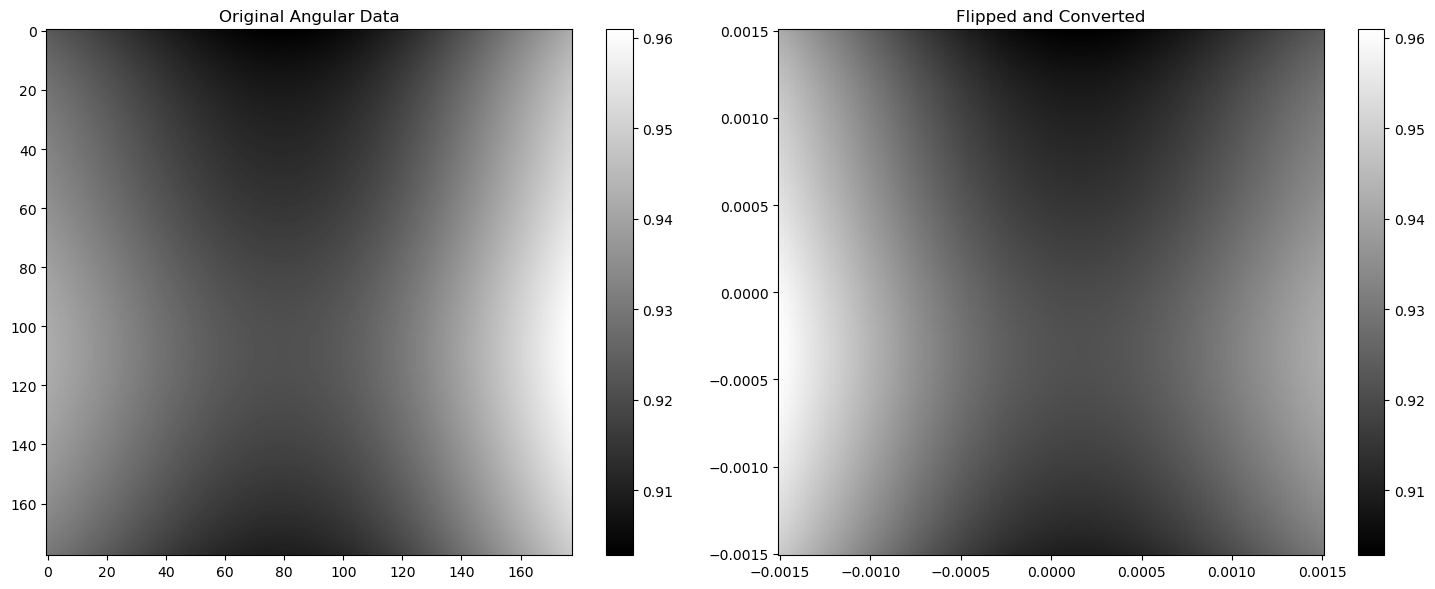

In [32]:
plt.clf()
plt.figure(figsize=(15, 6))

plt.subplot(1, 2, 1)
plt.imshow(emission_fit_cropped, cmap='gray')
plt.title('Original Angular Data')
plt.colorbar()

plt.subplot(1, 2, 2)
plt.pcolormesh(spot[...,0], spot[...,1], spot[...,2], cmap='gray')
plt.title('Flipped and Converted')
plt.colorbar()

plt.tight_layout()
plt.show()


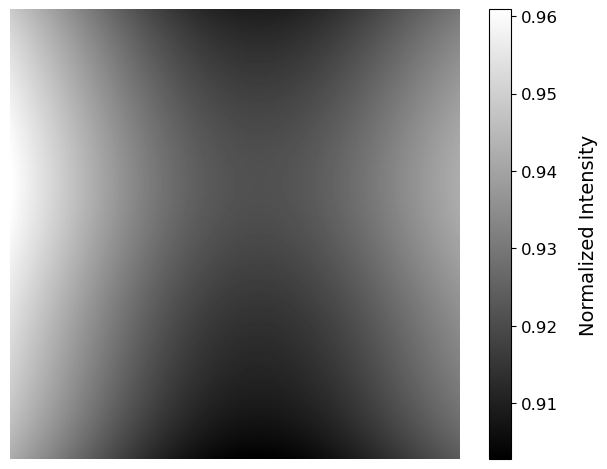

In [33]:
# Saving the figure for the light distribution incident on the photodiode
plt.clf()
plt.imshow(spot[...,2], cmap='gray')
plt.axis('off')
cbar = plt.colorbar()
cbar.ax.tick_params(labelsize=12)
# Increase the gap between the ticklaberl and the colorbar label
cbar.ax.yaxis.labelpad = 15

cbar.set_label("Normalized Intensity", fontsize=14)
plt.tight_layout()

plt.savefig("out/Power/Signal on PD.pdf", transparent=True)
plt.savefig("out/Power/Signal on PD.png", dpi=800, transparent=True)

plt.show()

In [34]:
# Selecting the indices that satisfy the condition
detector_mask_x = np.logical_and(spot_x < detector_size[0]/2, spot_x > -detector_size[0]/2)
detector_mask_y = np.logical_and(spot_y < detector_size[1]/2, spot_y > -detector_size[1]/2)
detector_mask = np.logical_and(detector_mask_x, detector_mask_y)

# Creating the detector_light matrix
detector_light = np.zeros((spot_x.shape[0], spot_x.shape[1], 3))
detector_light[detector_mask] = spot[detector_mask]

# Cropping to size
detector_light_m = np.argwhere(detector_light[:,:,2])
x_min, y_min = detector_light_m.min(axis=0)
x_max, y_max = detector_light_m.max(axis=0)

detector_light_cropped = detector_light[x_min:x_max, y_min:y_max, :]


In [38]:
emission_fit_cropped.shape

(178, 178)

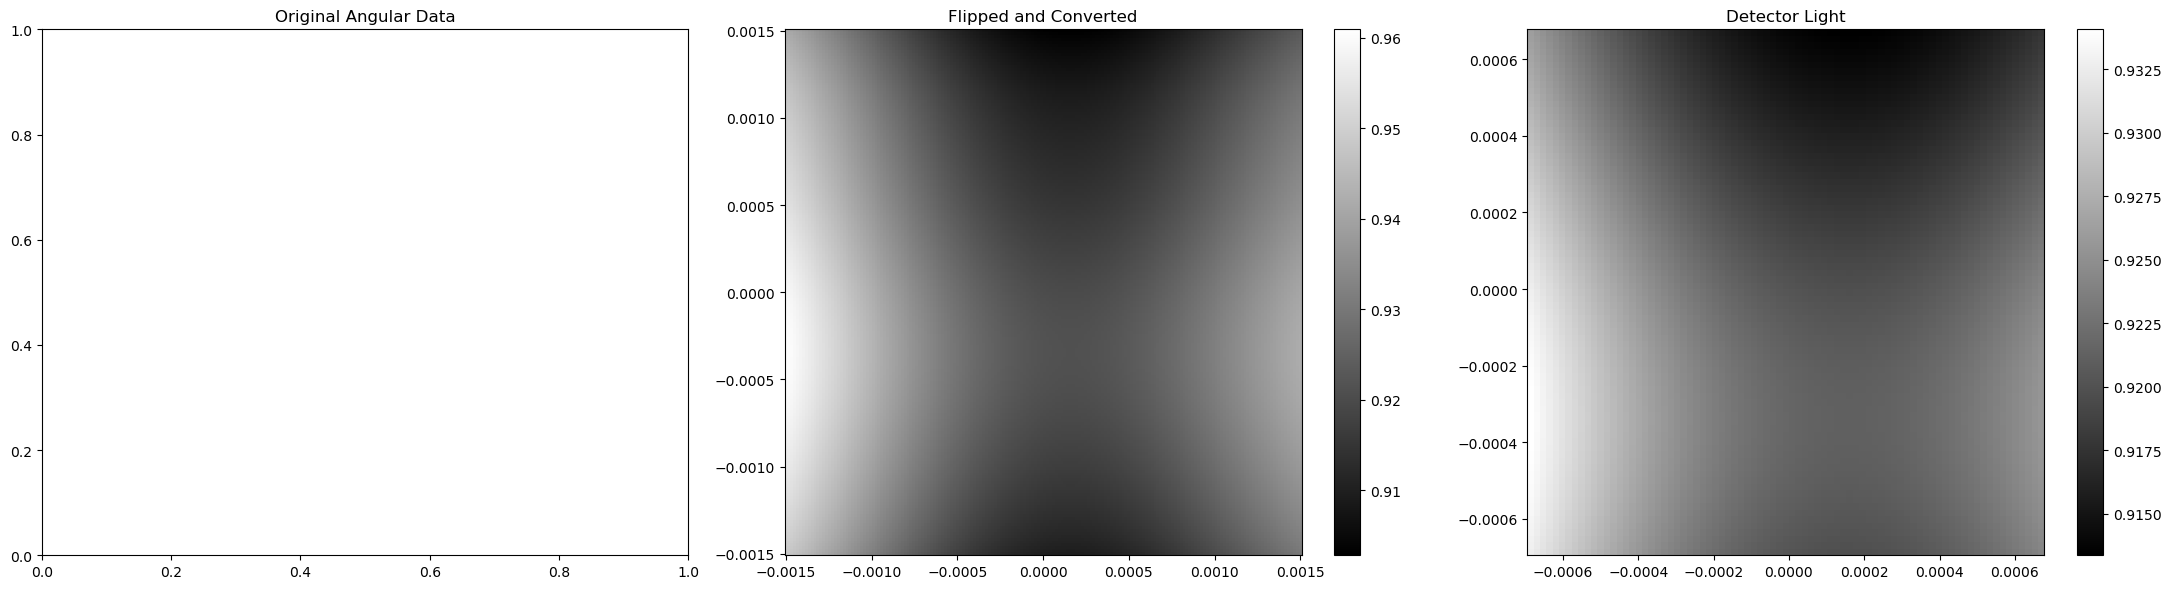

In [40]:
plt.figure(figsize=(22, 6))

plt.subplot(1, 3, 1)
# plt.pcolormesh(emission_fit_cropped[:,:,0], emission_fit_cropped[:,:,1], emission_fit_cropped[:,:,2], cmap='gray')
plt.title('Original Angular Data')
# plt.colorbar()

plt.subplot(1, 3, 2)
plt.pcolormesh(spot[...,0], spot[...,1], spot[...,2], cmap='gray')
plt.title('Flipped and Converted')
plt.colorbar()

plt.subplot(1, 3, 3)
plt.pcolormesh(detector_light_cropped[:,:,0], detector_light_cropped[:,:,1], detector_light_cropped[:,:,2], cmap='gray')
plt.title('Detector Light')
plt.colorbar()

plt.tight_layout()
plt.show()

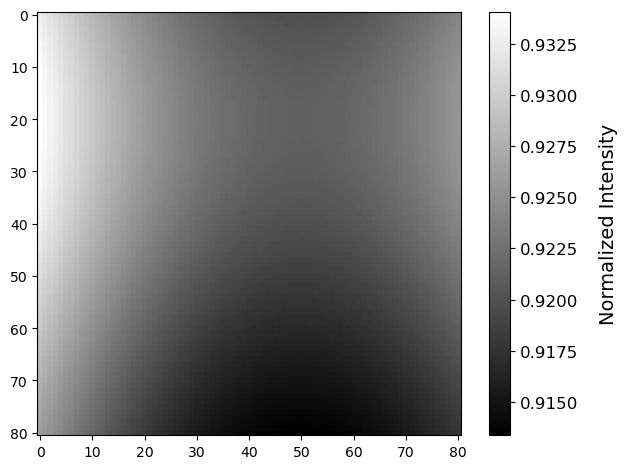

In [41]:
plt.clf()
plt.imshow(detector_light_cropped[:,:,2], cmap='gray')
cbar = plt.colorbar()
cbar.ax.tick_params(labelsize=12)
# Increase the gap between the ticklaberl and the colorbar label
cbar.ax.yaxis.labelpad = 15
# decimal_places = 2
# cbar.set_ticks([round(tick, decimal_places) for tick in cbar.get_ticks()])
cbar.set_label("Normalized Intensity", fontsize=14)
plt.tight_layout()
ax.axis('off')
plt.tight_layout()
plt.savefig("out/Power/Detector Light.pdf", transparent=True)
plt.savefig("out/Power/Detector Light.png", dpi=800, transparent=True)
plt.show()

## Applying the detector angular response on the detector image

Text(0.5, 1.0, 'Relative Luminence vs Angle')

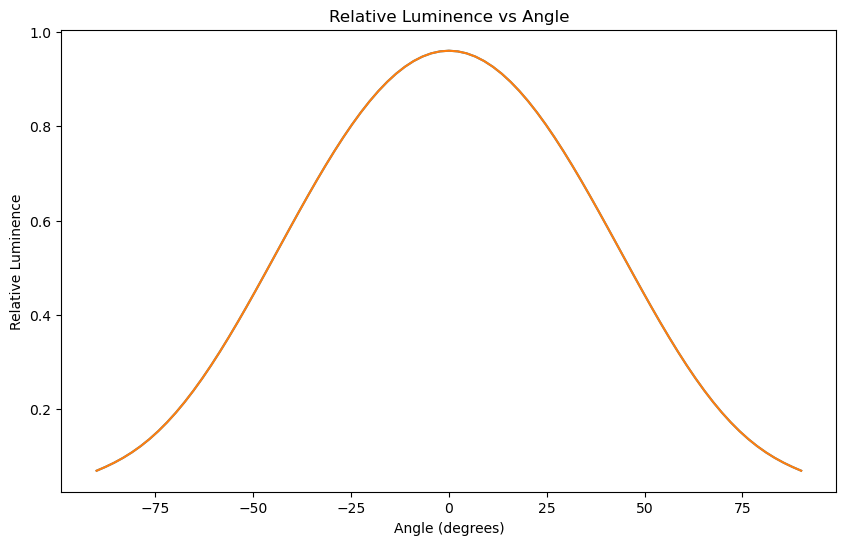

In [45]:
# Create a 1D array from pd_polynomial_fit
angles_pd_0 = np.linspace(-90, 90, detector_light_cropped.shape[0])
angles_pd_1 = np.linspace(-90, 90, detector_light_cropped.shape[1])

# Calculate from the fit
relative_luminescence_0 = pd_polyfit(angles_pd_0)
relative_luminescence_1 = pd_polyfit(angles_pd_1)

# Plot the data
plt.figure(figsize=(10, 6))
plt.plot(angles_pd_0, relative_luminescence_0, label='Relative Luminence vs Angle')
plt.plot(angles_pd_1, relative_luminescence_1, label='Relative Luminence vs Angle')
plt.xlabel('Angle (degrees)')
plt.ylabel('Relative Luminence')
plt.title('Relative Luminence vs Angle')

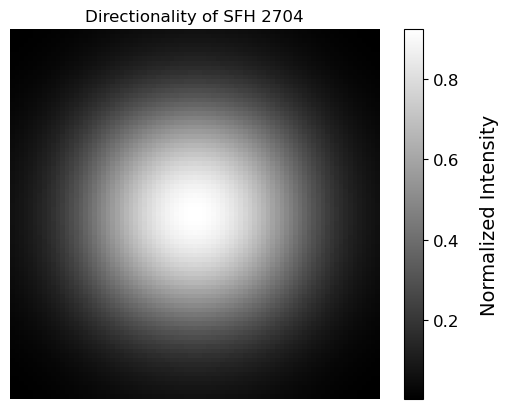

In [46]:
# Turn relative luminescence_fit_0 into a 2D array
relative_luminescence_0_2d = np.tile(relative_luminescence_0, (detector_light_cropped.shape[1], 1))

# Turn relative luminescence_fit_1 into a 2D array
relative_luminescence_1_2d = np.tile(relative_luminescence_1, (detector_light_cropped.shape[0], 1)).T

# Multiply the two arrays together
relative_luminescence_2d = relative_luminescence_0_2d * relative_luminescence_1_2d

# Plotting the directionality
plt.clf()
plt.imshow(relative_luminescence_2d, cmap='gray')
plt.axis('off')

cbar = plt.colorbar()
cbar.ax.tick_params(labelsize=12)
# Increase the gap between the ticklaberl and the colorbar label
cbar.ax.yaxis.labelpad = 15
# decimal_places = 2
# cbar.set_ticks([round(tick, decimal_places) for tick in cbar.get_ticks()])
cbar.set_label("Normalized Intensity", fontsize=14)
# plt.tight_layout()
plt.title('Directionality of SFH 2704')
plt.show()

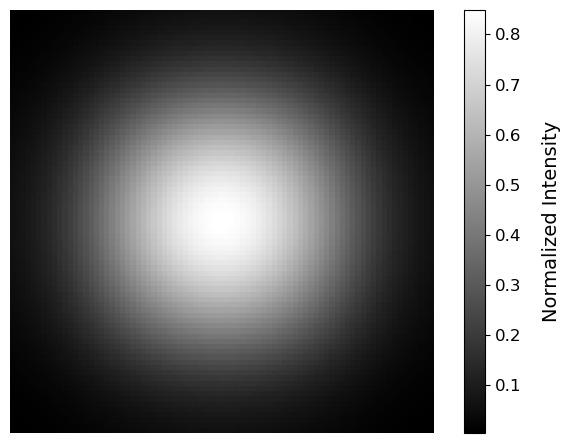

In [47]:
# Multiplying this directional characteristic with the detector light
detector_light_directional = detector_light_cropped.copy()
detector_light_directional[:,:,2] *= relative_luminescence_2d.T

# Plotting the directionality
plt.clf()
plt.imshow(detector_light_directional[:,:,2], cmap='gray')
plt.tight_layout()
plt.axis('off')

# Set the colorbar
cbar = plt.colorbar()
cbar.ax.tick_params(labelsize=12)

# Increase the gap between the ticklaberl and the colorbar label
cbar.ax.yaxis.labelpad = 15
cbar.set_label("Normalized Intensity", fontsize=14)

# Save the figures
plt.savefig("out/Power/Signal Detected.pdf", transparent=True)
plt.savefig("out/Power/Signal Detected.png", dpi=800, transparent=True)

# plt.title('Signal measured because of directionality')
plt.show()

## Calculating the photocurrent generated from the photodiode

In [55]:
# Calculating the total luminescence on the detector area
total_luminescence = np.zeros(len(meas_vals[:,2]))

for i in range(len(meas_vals[:,2])):
    total_luminescence[i] = np.sum(detector_light_directional[:,:,2] * meas_vals[i,2]) * ((np.pi * lens_radius**2)/(2*lens_focal_length)**2) * 10**-3

# Converting to Watt
total_power = total_luminescence / 683

# Converting to Intensity (power in mW from above and dividing by area of the photodiode detector (in cm^2) to get the final intensity in mW/cm^2)
final_intensity = total_power / 0.0151

# Amount of photocurrent generated by the photodiode (in microAmps)
photocurrent = final_intensity * 0.51

<Figure size 640x480 with 0 Axes>

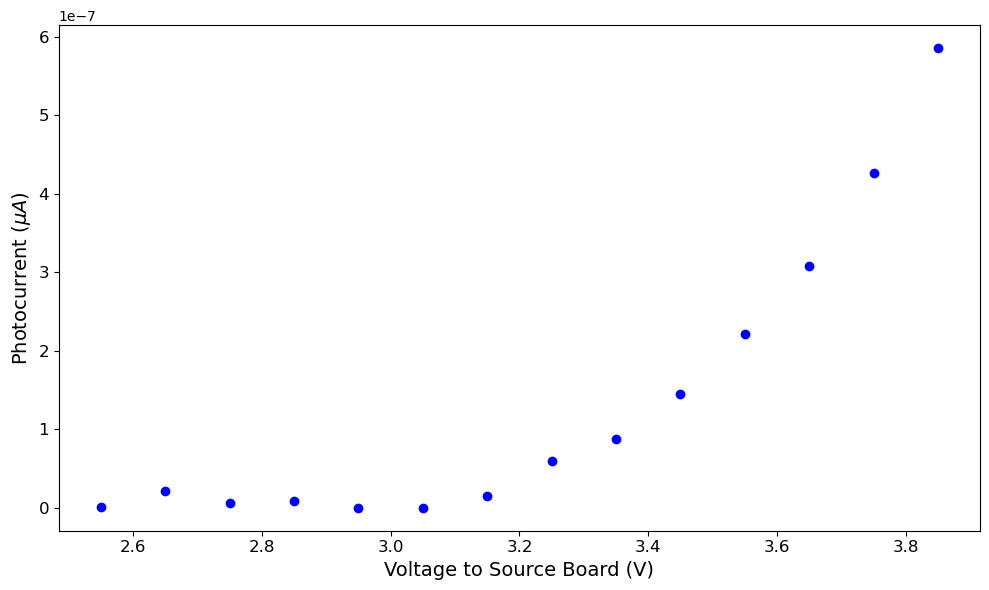

In [56]:
plt.clf()
# Plotting Voltage vs Photocurrent
plt.figure(figsize=(10, 6))
plt.scatter(meas_vals[:, 0], photocurrent, c='blue')
plt.xlabel('Voltage to Source Board (V)', fontsize=14)
plt.ylabel(r'Photocurrent ($\mu A$)', fontsize=14)
# Increase tick label size
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)

# Saving the figure
plt.tight_layout()
plt.savefig("out/Power/Photocurrent for input voltage.pdf", transparent=True)
plt.savefig("out/Power/Photocurrent for input voltage.png", dpi=800, transparent=True)

plt.show()
# plt.title('Photocurrent vs Voltage to Source Board')

In [69]:
# Calculating the power consumed with intensity

# Create a new dataframe df_power
df_power = pd.DataFrame({'Source Voltage': meas_vals[:, 0], 'Intensity': final_intensity, 'Photocurrent': photocurrent})

# Find the corresponding values from df_inter
df_power['Total Power'] = df_power['Source Voltage'].apply(lambda x: df_inter[df_inter['Source Board Voltage'] == x]['Total Power (mW)'].values[0])


In [70]:
df_power

,Source Voltage,Intensity,Photocurrent,Total Power
0,2.55,62.989050,32.124416,5.9670
1,2.65,854.712519,435.903385,6.8635
2,2.75,217.931474,111.145052,8.1125
3,2.85,333.631810,170.152223,9.6045
4,2.95,18.456005,9.412563,11.5935
5,3.05,7.727841,3.941199,14.0605
6,3.15,603.740656,307.907735,17.1045
7,3.25,2330.675187,1188.644345,20.5725
8,3.35,3407.445300,1737.797103,24.5555
9,3.45,5605.799097,2858.957539,29.1525


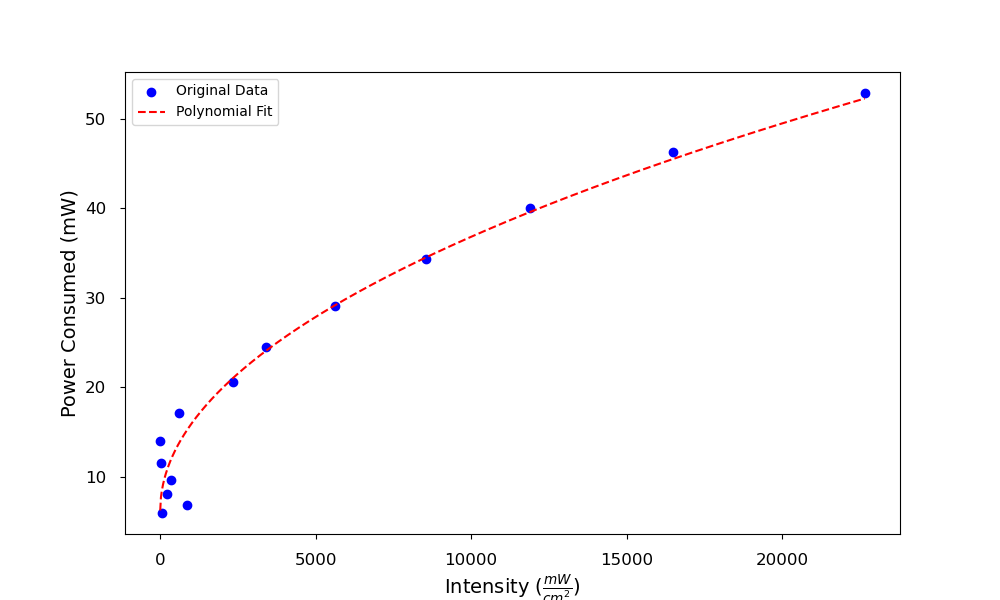

In [71]:
def fit_func_int_pow(x, a, b):
    # return (a*np.log10(x)**2 + b*np.log10(x))
    return (a*np.sqrt(x) + b)

# Fit this plot with a polynomial
int_pow_params, _ = curve_fit(fit_func_int_pow, df_power['Intensity'], df_power['Total Power'])
x_inter_int_pow_fit = np.linspace(0, max(df_power['Intensity']), 1000)
inter_int_pow_fit = fit_func_int_pow(x_inter_int_pow_fit, *int_pow_params)

# Plot of power consumed vs incident intensity
plt.clf()
plt.figure(figsize=(10, 6))

plt.scatter(df_power['Intensity'], df_power['Total Power'], c='blue', label='Original Data')
plt.plot(x_inter_int_pow_fit, inter_int_pow_fit, c='red', linestyle='--', label='Polynomial Fit')

plt.xlabel(r'Intensity $(\frac{mW}{cm^2})$', fontsize=14)
plt.ylabel('Power Consumed (mW)', fontsize=14)
plt.tick_params(axis='both', which='major', labelsize=12)

plt.legend()
plt.show()

C:\Users\nkottap\AppData\Local\Temp\ipykernel_23916\588166428.py:2: RuntimeWarning: divide by zero encountered in log10
  return (a*np.log10(x)**2 + b*np.log10(x))


Text(0.5, 1.0, 'Power Consumed vs Photocurrent')

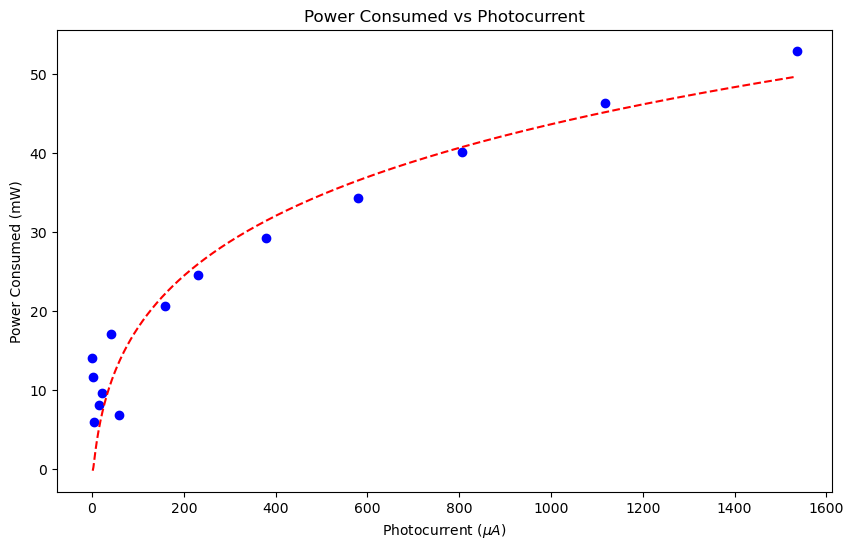

In [32]:
def fit_func_pc_pow(x, a, b):
    return (a*np.log10(x)**2 + b*np.log10(x))

# Fit this plot with a polynomial
pc_pow_params, _ = curve_fit(fit_func_pc_pow, df_power['Photocurrent'], df_power['Total Power'])
x_inter_pc_pow_fit = np.linspace(0, max(df_power['Photocurrent']), 1000)
inter_pc_pow_fit = fit_func_pc_pow(x_inter_pc_pow_fit, *pc_pow_params)

# Plot of power consumed vs photocurrent
plt.figure(figsize=(10, 6))
plt.scatter(df_power['Photocurrent'], df_power['Total Power'], c='blue')
plt.plot(x_inter_pc_pow_fit, inter_pc_pow_fit, c='red', linestyle='--', label='Polynomial Fit')
plt.xlabel(r'Photocurrent $(\mu A)$')
plt.ylabel('Power Consumed (mW)')
plt.title('Power Consumed vs Photocurrent')

In [33]:
# Selecting the photocurrent value under consideration to be 0.8 microAmps
# This number is just an educated guess based on the amplification and matching the detected light leqvel so that light decay through the system is non-existent
# Might be suspect as with the amplification and the desired photocurrent, we get 2nA. Setting this value instead of 0.8 uA
# pc_val = 0.8
pc_val = 0.002

# Number of channels on the board
num_channels = 32

# Find the power consumed at this value
power_consumed = fit_func_pc_pow(pc_val, *pc_pow_params) * 10**-3

# Decided to use experimental and design values instead
power_consumed = (0.8 * 10**-3) * 3.5

In [34]:
power_consumed * num_channels

0.0896

# Electronic Transfer Function

## Optical Losses

In [35]:
# Calculating the losses
# Conversion efficiency from electrical signal of the LED to the optical signal from the LED
led_electronic_conversion_efficiency = 0.15

# SLM losses
slm_losses = 0.5

# Total amount of light blocked due to weight matrices
weight_matrix_values = 0.1

# Loss due to differencing operations
differencing_operation_values = 0.2

# Losses due to the offset of the array from the idealized center
array_center_offset_losses_2d = 0.5

# Losses due to the photodiode fill factor
pd_fill_factor = 0.125

# Losses due to diffraction at the edges of the array
diffraction_edge_losses = 0.5

# Loss due to the selection of a narrow angular response from the photodiode
pd_angle_losses = 0.7

# Calculating the total losses
total_losses = led_electronic_conversion_efficiency * slm_losses * weight_matrix_values * differencing_operation_values * array_center_offset_losses_2d * pd_fill_factor * diffraction_edge_losses * pd_angle_losses

print(1/(total_losses))

30476.190476190477


## Relationship between bandwidth and minimum optical power
Calculating the relationship between the minimum optical power needed to run the system vs the system bandwidth. The following equations are used in this calculations
The total bandwidth of the system can be calculated as 
$$\textrm{Total Bandwidth} = \Bigg(\frac{1}{f_{c_1}^2} + \frac{1}{f_{c_2}^2} \Bigg)^{-\frac{1}{2}} $$
As the first stage is a non-inverting amplifier, the first stage's bandwidth can be calculated as follows
$$f_{-3dB} = \sqrt{\frac{\textrm{GBW}}{2\pi R_f C_{tot}}} \textrm{Hz}$$
The minimum optical power needed can then be calculated from the minimum power as 
$$P_{min} = \textrm{NEP} \cdot \sqrt{f_{-3dB}^{sys}} \cdot \textrm{SNR}$$

This last equation can be used to find the optimum bandwidth in lieu of the noise response of the system

In [36]:
# Defining as a small function to ease calculation
def tia_bandwidth(GBW, Rf, C_tot):
    return np.sqrt(GBW / (2 * np.pi * Rf * C_tot))

def vf_bandwidth(GBW):
    return GBW

def min_power_calc(bandwidth, noise_equivalent_power, snr):
    return noise_equivalent_power * np.sqrt(bandwidth) * snr

def total_bandwidth_calc(bandwidth_1, bandwidth_2):
    return 1/np.sqrt((1/bandwidth_1**2) + (1/bandwidth_2**2))


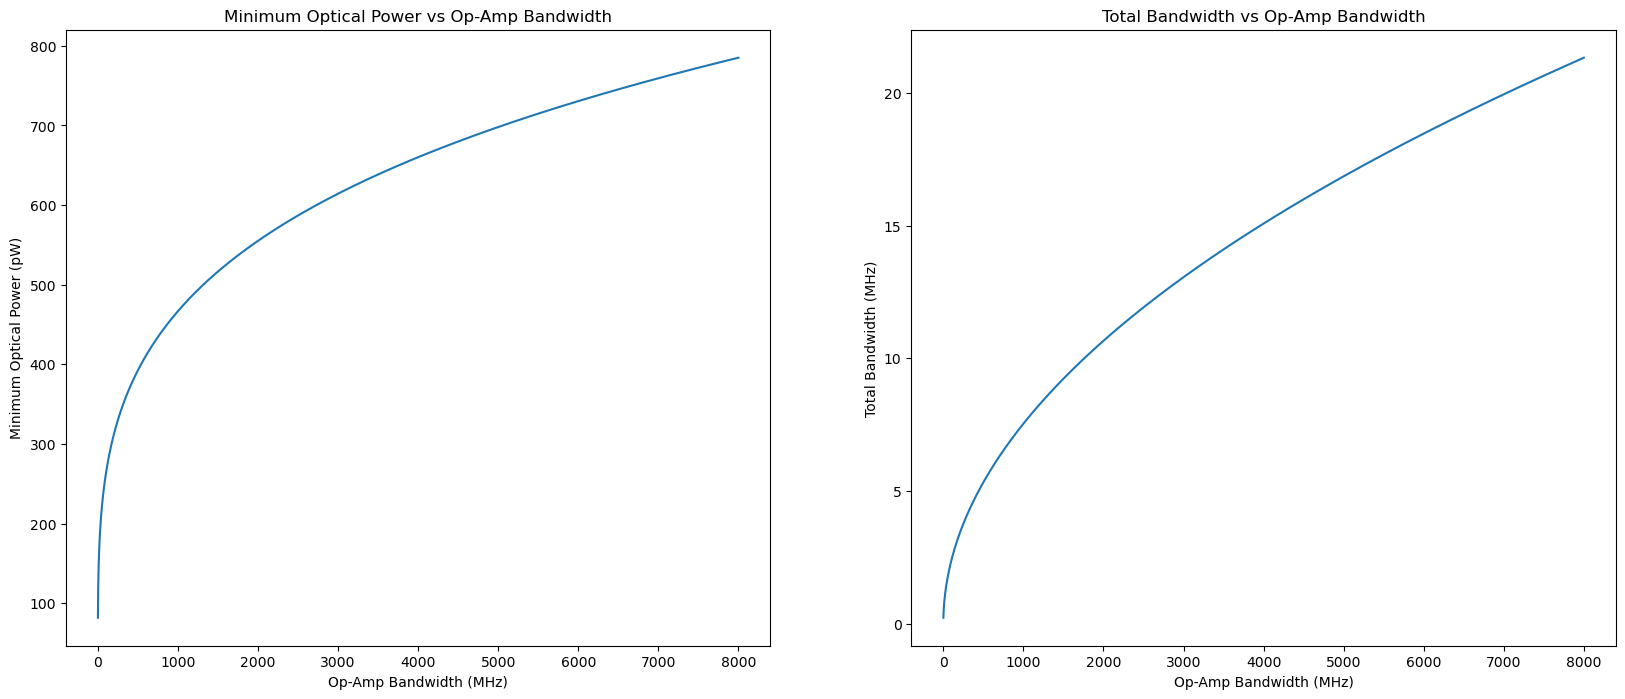

In [37]:
# Possible bandwidth ranges on the op-amps that we could choose
oa_bandwidth_range = np.linspace(1e6, 8e9, 10000)

# Fixing the feedback resistance value (to maintain the gain) and for the same PCB design and photodiode capacitance (8pF at -4V bias)
Rf = 350 * 1e3
Rl = 10
Cf = 8 * 1e-12

# Parameters from the photodiode
noise_equivalent_power = 0.017 * 1e-12
snr = 10

# Calculating the minimum optical power
min_power = min_power_calc(total_bandwidth_calc(tia_bandwidth(oa_bandwidth_range, Rf, Cf), vf_bandwidth(oa_bandwidth_range)), noise_equivalent_power, snr)

# Plotting the minimum optical power vs the op-amp bandwidth
plt.figure(figsize=(20, 8))
plt.subplot(121)
plt.plot(oa_bandwidth_range/1e6, min_power/1e-12)
plt.xlabel('Op-Amp Bandwidth (MHz)')
plt.ylabel('Minimum Optical Power (pW)')
plt.title('Minimum Optical Power vs Op-Amp Bandwidth')

plt.subplot(122)
plt.plot(oa_bandwidth_range/1e6, total_bandwidth_calc(tia_bandwidth(oa_bandwidth_range, Rf, Cf), vf_bandwidth(oa_bandwidth_range))/1e6)
plt.xlabel('Op-Amp Bandwidth (MHz)')
plt.ylabel('Total Bandwidth (MHz)')
plt.title('Total Bandwidth vs Op-Amp Bandwidth')
plt.show()


In [38]:
np.max(total_bandwidth_calc(tia_bandwidth(oa_bandwidth_range, Rf, Cf), vf_bandwidth(oa_bandwidth_range))/1e6)

21.324286106499603

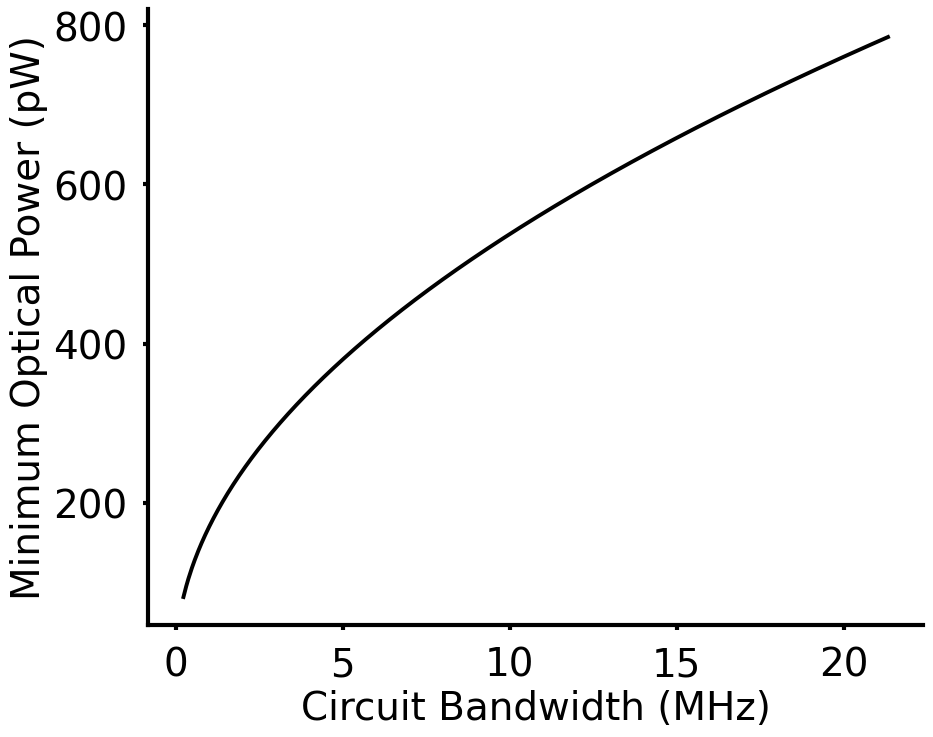

In [68]:
plt.style.use('seaborn-v0_8-poster')
fig, ax = plt.subplots(figsize=(10, 8))
plt.plot(total_bandwidth_calc(tia_bandwidth(oa_bandwidth_range, Rf, Cf), vf_bandwidth(oa_bandwidth_range))/1e6, min_power/1e-12, '-', color='k')
ax.set_xlabel('Circuit Bandwidth (MHz)', fontsize=28)
ax.set_ylabel('Minimum Optical Power (pW)', fontsize=28)

ax.tick_params(axis='both', labelsize=28, width=3)

# Increase the line thickness of the bounding box
for spine in ax.spines.values():
    spine.set_linewidth(3)

# Remove splines on top and right sides
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
    
# Add splines on left and bottom sides
ax.spines['bottom'].set_visible(True)
ax.spines['left'].set_visible(True)

plt.savefig('out/Power/Minimum Power.svg', bbox_inches='tight')
plt.show()


## Power consumption
Calculating the power consumption of the board assuming an 80% efficiency of the amplifier circuit and an op-amp with a bandwidth of 90MHz 

In [40]:
# Choosing the bandwidth of the op-amp to be 40MHz to have a good frequency response of the circuit
total_bandwidth_sel = total_bandwidth_calc(tia_bandwidth(40e6, Rf, Cf), vf_bandwidth(40e6))
min_power_sel = min_power_calc(total_bandwidth_sel, noise_equivalent_power, snr)

# Calculating the maximum photocurrent
sensitivity_pd = 0.34 # A/W
photocurrent = sensitivity_pd * min_power_sel

# Current through LED
gain_ckt = Rf/Rl
led_current = photocurrent * gain_ckt
led_light = led_lum_fit(led_current, *popt_led_lum)

led_light

26986.339853694837

In [41]:
# power_consumed = 1.2 * (led_current * 4)
# power_consumed

# Calculating the number of operations performed by the board
An operation in this instance can be defined a multiplicative operation perfromed by the scheme. The modulation of light emitted from a single LED modulated by a single mini-block can be treated as a product. For an emitter board the size of $m_e \times n_e$ and the detector board of size $m_d \times n_d$, for a single element on the emitter board, the total number of operations that happen are $m_d \times m_e \times n_d \times n_e$. 

For the boards used for this calculation, the following parameters are used
1. $m_d = 4$
2. $n_d = 8$
3. $m_e = 8$
4. $n_e = 8$ 

So for a single layer at a single time step, this gives us the multiplicative operations to be 2048. In addition, we also have 32 subtraction operations. So, the total number of operations at a single time step becomes 2080. However the system has been tested to operate at 500 kHz. This means that there are 500 kHz operations that are occuring in a second. So the total number of operations a second is $5 \cdot 10^8 \times 2080 = 1.04 \;\text{TOPS}$

The system in total consumes $327.33 \; \text{mW}$ for the amount of light that is in the system. This gives us a final value of $3.18 \;\text{TOPS/W}$. This is in contrast to the value for the top of the line GPU for AI, that is Nvidia H100 which is $0.59 \; \text{TOPS/W}$. However H100s performance might be better if we consider it's FP8 performance which gives $8.8\; \text{TOPS/W}$. However, use of FP8 for neural networks is currently being examined and is not in use for applications at the moment.  In the world of ASICs, Google TPU v4, the leading machine learning ASIC in its latest iteration has $1.6 \;\text{TOPS/W}$.

To conclude, the system is quite competitive when compared to existing systems


**Links**
1. [NVIDIA RTX 4090](https://www.techpowerup.com/gpu-specs/geforce-rtx-4090.c3889)
2. [NVIDIA H100](https://www.techpowerup.com/gpu-specs/h100-pcie-80-gb.c3899)
3. [Google TPU v4](https://en.wikipedia.org/wiki/Tensor_Processing_Unit)

## Individual case
### Experimental Condition

In [77]:
## Testing for the experimental conditions
# Setting the number of TOPS/W for our system
dim_exp = [8,8]
freq_exp = 1 * 1e6
num_op_exp = (dim_exp[0]**2 * dim_exp[1]**2 * 0.5)+(dim_exp[0]/2 * dim_exp[1])+(dim_exp[0] * dim_exp[1])
num_ops_exp = num_op_exp * (freq_exp)
tops_w = num_ops_exp/(power_consumed * num_channels * 1e9)

In [78]:
tops_w

23.928571428571427

### Maximum under diffraction limit

In [44]:
# Theoretical diffraction limit on size scaling of the system
max_arr_size = [32, 32]

# Maximum Permissible under scaling laws
# Number of ops for the max array size
op_max = (max_arr_size[0] * max_arr_size[1] * max_arr_size[0]/2 * max_arr_size[1])+(max_arr_size[0]/2 * max_arr_size[1])
ops_max = op_max * (500 * 10**6)

# Assuming that the power consumption stays the same as the light level in the system stays the same and we can indefinitely scale it down to less than 1 photon/operation (cite McMahon paper). This holds true as from the power measurements for a single channel, it is clear that the majority of the power is consumed by the LED. The power consumed by the rest of the system is negligible in comparison.
# Calculate the power consumed per operation for the case of maximum operations
tops_w_max = ops_max/(power_consumed * num_channels)/10**12

## Plotting the scaling
### Scaling with size

In [45]:
# Creating an arry of detector_size
dim_arr = np.zeros((13, 2))
dim_arr[:, 0] = np.arange(8, 34, 2)
dim_arr[:, 1] = np.arange(8, 34, 2)

# Calculating the number of operations at a time step
op_arr = (dim_arr[:, 0]**2 * 0.5 * dim_arr[:, 1]**2) + (dim_arr[:, 0] * 0.5 * dim_arr[:, 1])

# Calculating the number of operations per second
ops_arr = op_arr * (5 * 10**5)

# Calculating the power consumed per operation
tops_w_arr = ops_arr/(power_consumed * num_channels * 10**12)

In [46]:
tops_w_arr

array([0.01160714, 0.0281808 , 0.05825893, 0.10773437, 0.18357143,
       0.2938058 , 0.44754464, 0.65496652, 0.92732143, 1.2769308 ,
       1.7171875 , 2.2625558 , 2.92857143])

In [73]:
power_consumed * num_channels
tops_w_arr

array([0.01160714, 0.0281808 , 0.05825893, 0.10773437, 0.18357143,
       0.2938058 , 0.44754464, 0.65496652, 0.92732143, 1.2769308 ,
       1.7171875 , 2.2625558 , 2.92857143])

Text(0.5, 1.0, 'Scaling with increasing size of array')

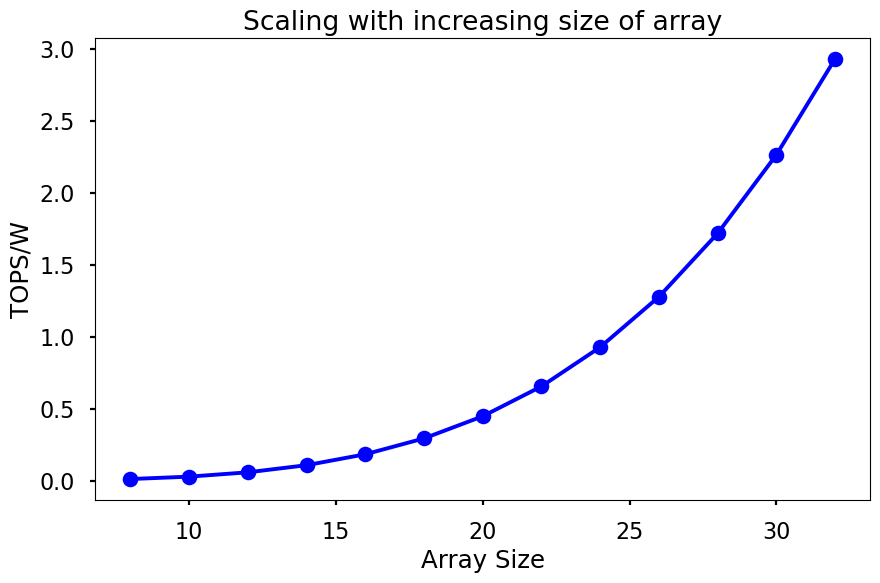

In [48]:
# Plot the data
plt.figure(figsize=(10, 6))
plt.plot(dim_arr[:,0], tops_w_arr, 'o-', c='blue')
plt.xlabel('Array Size')
plt.ylabel('TOPS/W')
plt.title('Scaling with increasing size of array')

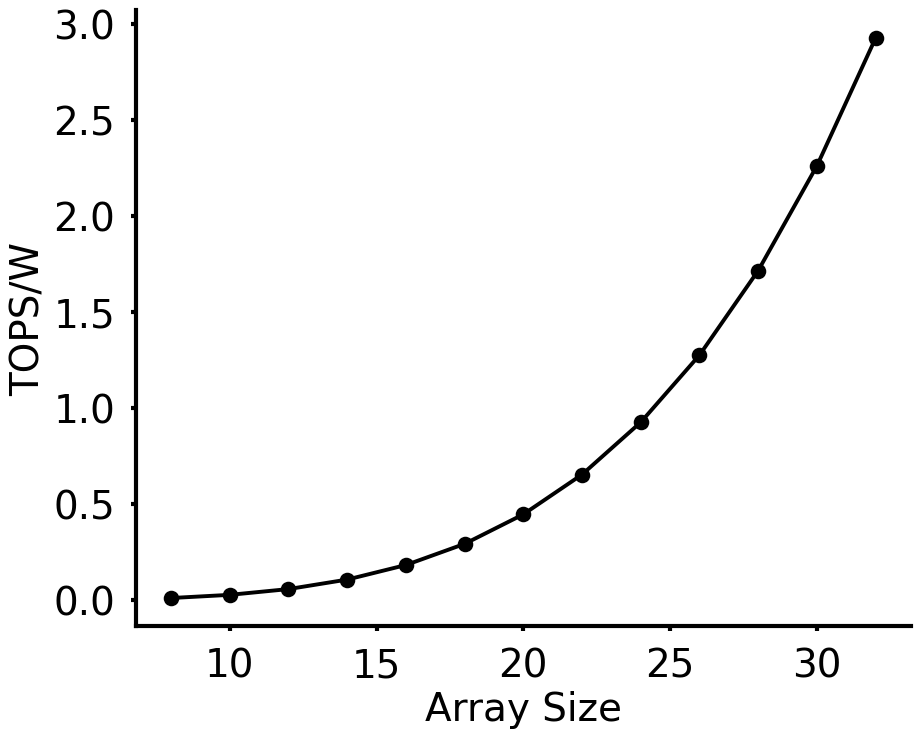

In [49]:
plt.style.use('seaborn-v0_8-poster')
fig, ax = plt.subplots(figsize=(10, 8))

plt.plot(dim_arr[:,0], tops_w_arr, 'o-', c='k')
# plt.title('Scaling with increasing size of array')
# ax.legend(fontsize=28)

ax.set_ylabel('TOPS/W', fontsize=28)
ax.set_xlabel('Array Size', fontsize=28)

ax.tick_params(axis='both', labelsize=28, width=3)

# Increase the line thickness of the bounding box
for spine in ax.spines.values():
    spine.set_linewidth(3)

# Remove splines on top and right sides
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
    
# Add splines on left and bottom sides
ax.spines['bottom'].set_visible(True)
ax.spines['left'].set_visible(True)

plt.savefig('out/Power/power-size-scaling (0,8).pdf', bbox_inches='tight')
plt.show()


### Scaling with frequency
There are commercially available 1GSPS ADC chip such as [ADC08D1000](https://www.ti.com/lit/ds/symlink/adc08d1000.pdf?ts=1701709167422&ref_url=https%253A%252F%252Fwww.google.com%252F) from Texas instruments. However the limitation in that is power consumption and complexity of supporting electronics. Additionally the limitation with data-transfer rates gets into play here. The data-rate required to process  single channel at 1GSPS is 8Gbps. When we scale this out to array sizes such as $32 \times 32$, we get to a data-rate of  8.192 Tbps and the cards with fastest transfer rates is 512 Gbps with PCI Express v5 x16 ([source](https://www.electronicshub.org/how-many-pcie-lanes-do-i-have/)). So we need 16 PCI Express v5 ×16 lanes to process this amount of data which leads to the main bottleneck. For demonstration, we consider datarates that are feasible with a single PCIe v5 ×16 connector which would be 62.5MSPS

In [50]:
# Creating an array of frequencies
freq_arr = np.arange(0.5, np.max(total_bandwidth_calc(tia_bandwidth(oa_bandwidth_range, Rf, Cf), vf_bandwidth(oa_bandwidth_range)))/1e6, 1) * 10**6

# Setting other parameters
dim_freq_arr_1 = [32, 32]
dim_freq_arr_2 = [16, 16]
dim_freq_arr_3 = [8, 8]

# Calculating
# Calculating the number of operations at a time step
op_arr_1 = (dim_freq_arr_1[0]**2 * 0.5 * dim_freq_arr_1[1]**2) + (dim_freq_arr_1[0] * 0.5 * dim_freq_arr_1[1])
op_arr_2 = (dim_freq_arr_2[0]**2 * 0.5 * dim_freq_arr_2[1]**2) + (dim_freq_arr_2[0] * 0.5 * dim_freq_arr_2[1])
op_arr_3 = (dim_freq_arr_3[0]**2 * 0.5 * dim_freq_arr_3[1]**2) + (dim_freq_arr_3[0] * 0.5 * dim_freq_arr_3[1])

# Calculating the number of operations per second
ops_arr_1 = op_arr_1 * freq_arr
ops_arr_2 = op_arr_2 * freq_arr
ops_arr_3 = op_arr_3 * freq_arr

# Calculating the power consumed per operation
tops_w_arr_1 = ops_arr_1/(power_consumed * num_channels * 10**12)
tops_w_arr_2 = ops_arr_2/(power_consumed * num_channels * 10**12)
tops_w_arr_3 = ops_arr_3/(power_consumed * num_channels * 10**12)

In [51]:
tops_w_arr_1

array([  2.92857143,   8.78571429,  14.64285714,  20.5       ,
        26.35714286,  32.21428571,  38.07142857,  43.92857143,
        49.78571429,  55.64285714,  61.5       ,  67.35714286,
        73.21428571,  79.07142857,  84.92857143,  90.78571429,
        96.64285714, 102.5       , 108.35714286, 114.21428571,
       120.07142857])

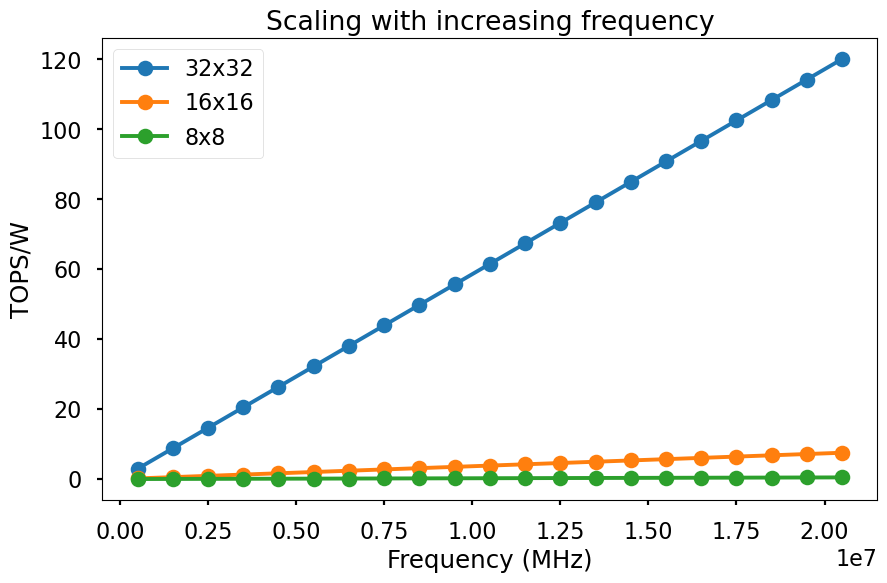

In [52]:
# Plot the data
plt.figure(figsize=(10, 6))
plt.plot(freq_arr, tops_w_arr_1, 'o-', label='32x32')
plt.plot(freq_arr, tops_w_arr_2, 'o-', label='16x16')
plt.plot(freq_arr, tops_w_arr_3, 'o-', label='8x8')
plt.xlabel('Frequency (MHz)')
plt.ylabel('TOPS/W')
plt.title('Scaling with increasing frequency')
plt.legend()


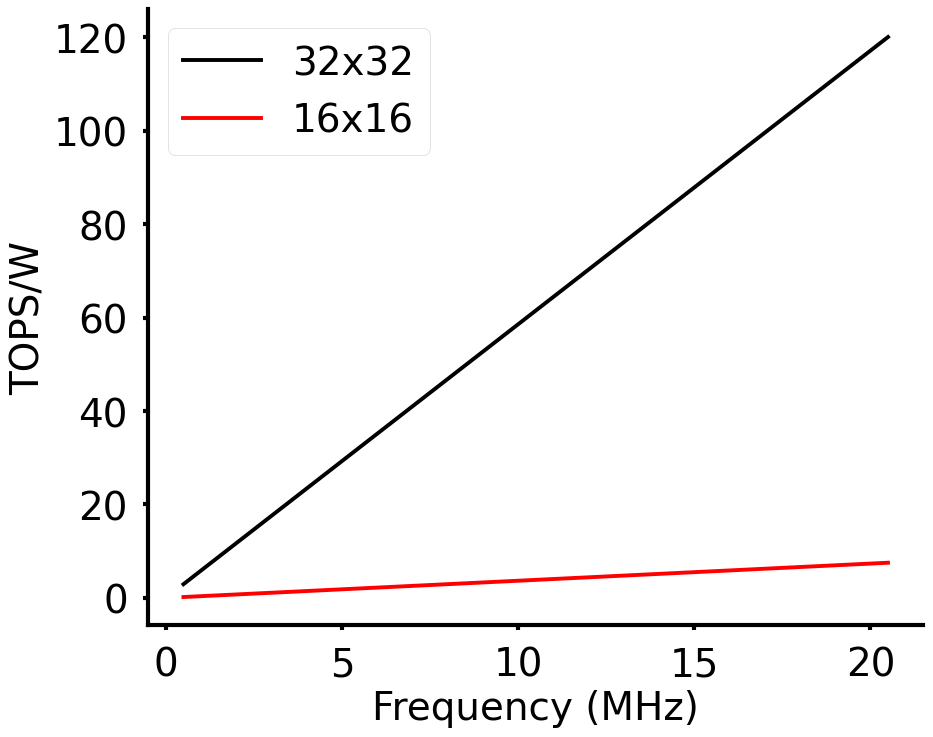

In [53]:
plt.style.use('seaborn-v0_8-poster')
fig, ax = plt.subplots(figsize=(10, 8))

plt.plot(freq_arr/1e6, tops_w_arr_1, '-', c='k', label='32x32')
plt.plot(freq_arr/1e6, tops_w_arr_2, '-', c='r', label='16x16')

# plt.title('Scaling with increasing size of array')
ax.legend(fontsize=28)

ax.set_ylabel(r'TOPS/W', fontsize=28)
ax.set_xlabel('Frequency (MHz)', fontsize=28)

ax.tick_params(axis='both', labelsize=28, width=3)

# Increase the line thickness of the bounding box
for spine in ax.spines.values():
    spine.set_linewidth(3)

# Remove splines on top and right sides
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
    
# Add splines on left and bottom sides
ax.spines['bottom'].set_visible(True)
ax.spines['left'].set_visible(True)

plt.savefig('out/Power/power-speed-scaling (0,8).pdf', bbox_inches='tight')
plt.show()


C:\Users\nkottap\AppData\Local\Temp\ipykernel_23916\1430203364.py:12: RuntimeWarning: divide by zero encountered in divide
  return 1/np.sqrt((1/bandwidth_1**2) + (1/bandwidth_2**2))


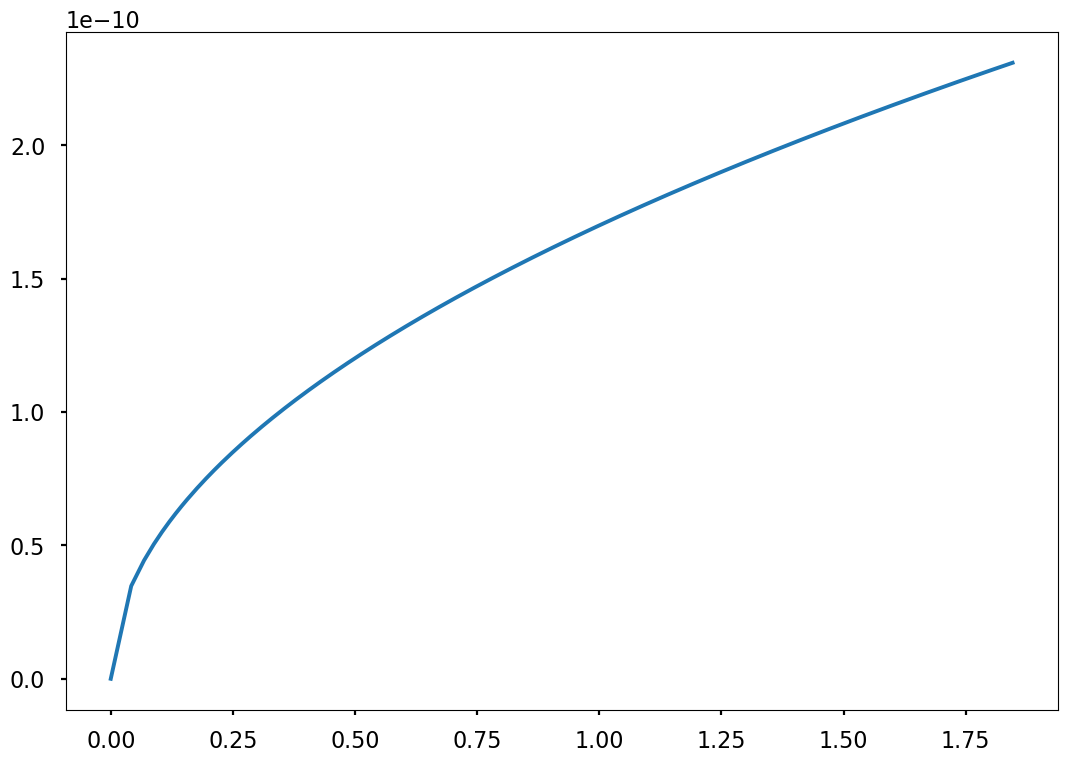

In [54]:
plt.plot(total_bandwidth_calc(tia_bandwidth(np.linspace(0,60*1e6, 1000), Rf, Cf), vf_bandwidth(np.linspace(0,60*1e6, 1000)))/1e6, min_power_calc(total_bandwidth_calc(tia_bandwidth(np.linspace(0,60*1e6, 1000), Rf, Cf), vf_bandwidth(np.linspace(0,60*1e6, 1000))), noise_equivalent_power, snr),  label='min')


# Caculating for a 2nA photocurrent through the photodiodes

In [55]:
intensity = 0.8 * 10**-3 # mW/cm^2
# Calculating the amount of voltage that would have been necessary at the source board to get the desired photocurrent
power = (intensity * 151)
luminescence = power * 683
light_from_source = luminescence / np.sum(detector_light_directional[...,2])

# Converting to the light-field pre-photodiode
inverse_light_pd = spot.copy()
inverse_light_pd[...,2] = spot[...,2] * (light_from_source / np.sum(detector_light_cropped[...,2]))

# Skipping all the intermediate steps as we ar eonly interested in the sum at this stage and not in the exact shape of the beam

# Applying the lens factor
inverse_light_led = emission_fit.copy()
inverse_light_led[...,2] = emission_fit[...,2] * (np.sum(inverse_light_pd[...,2])/np.sum(emission_fit_cropped)) * (1/emission_fit_ratio)

# Calculaing the value of light from LED
inverse_led_light = np.unique(np.round(inverse_light_led[...,2] / emission_fit[...,2], 9))[0] * 10**3 # mCd

# Calculating the current through the LED


It is not possible to generate such little light from the LED with the current setup for characterizing. So trying out an alternate whereby I force the fits to go through (0,0) to get a better estimate of the problem